
# Compréhension du métier



*   Dans le domaine de la reconnaissance des émotions dans les signaux
audio, la clarté et la précision de la transmission émotionnelle sont d’une importance capitale.


*   
Les systèmes émotionnellement intelligents sont de plus en plus précieux dans des secteurs tels que le service client, la surveillance de la santé mentale, l’interaction homme-machine et les assistants virtuels personnalisés.

*  Pouvoir détecter automatiquement l’état émotionnel d’un locuteur aide les entreprises à améliorer l’expérience utilisateur, à adapter les services aux besoins individuels et à répondre de manière plus empathique lors des interactions en temps réel.






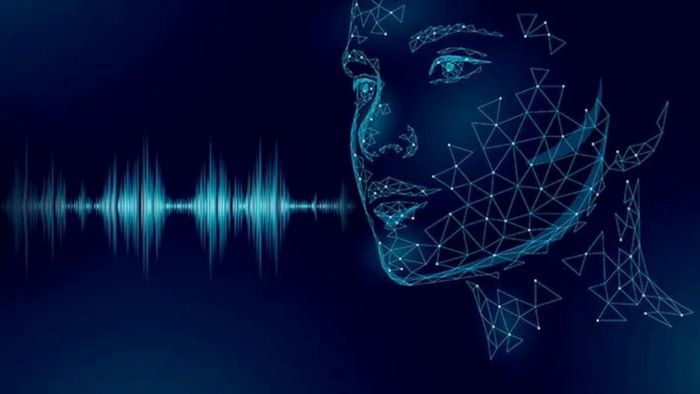

# Chargement des librairies

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
from torchvision import models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from torchvision.models import resnet50, ResNet50_Weights
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive_new')

Mounted at /content/drive_new


# Compréhension des données

**Importation de Radvess à partir du drive**


🎤 **RAVDESS** est une base de données audio-visuelle contenant des enregistrements vocaux et des performances chantées exprimant différentes émotions.

👥 Elle est composée d’enregistrements audio de 24 acteurs (12 hommes et 12 femmes) exprimant huit émotions principales : neutre, calme, heureux, triste, en colère, effrayé, dégoûté et surpris.

📂 Les fichiers audio sont en format WAV avec une fréquence d’échantillonnage standard (16 kHz ou 48 kHz selon la version).

**La Distribution des emotions dans Radvess**

*RAVDESS format :*

**Modality - Vocal channel - Emotion - Emotional intensity - Statement - Repetition - Actor**

🎙️ **Modality** : Type de données, par exemple vocal (speech) ou chant (song).

🔊**Vocal channel** : Canal audio utilisé, souvent mono (1) ou stéréo (2).

😃 **Emotion** : L’émotion exprimée dans l’enregistrement (par exemple : neutre, calme, heureux, triste, en colère, effrayé, dégoûté, surpris).

📈**Emotional intensity** : Intensité de l’émotion, souvent codée (par exemple : faible ou forte).

💬 **Statement** : Le texte prononcé dans l’enregistrement (RAVDESS contient un nombre limité de phrases standards).

🔁 **Repetition**: Le numéro de répétition de la phrase par l’acteur (exemple : première ou deuxième fois).

👤 **Actor** : Identifiant de l’acteur qui réalise l’enregistrement (par exemple acteur 01 à 24).

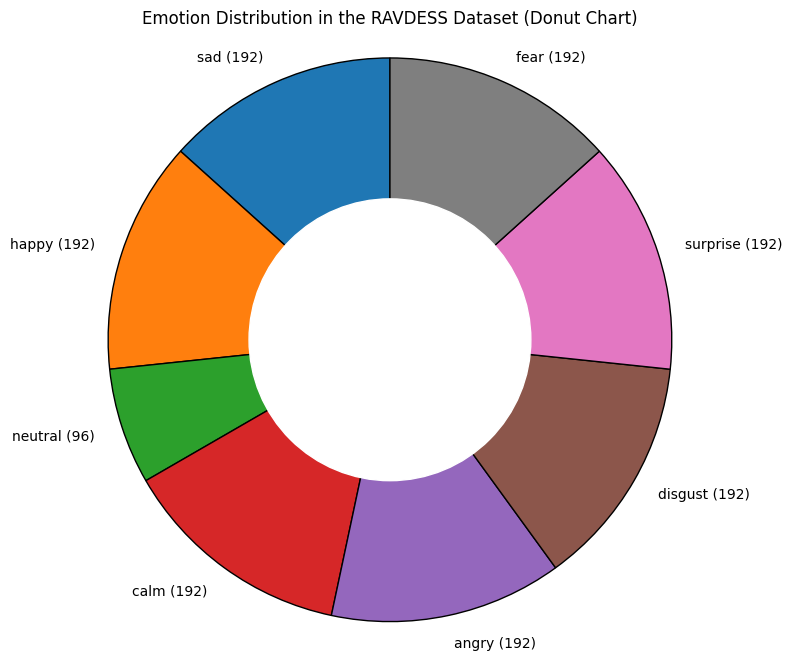

In [ ]:
import os
import matplotlib.pyplot as plt
from collections import Counter

# Dictionnaire des émotions pour RAVDESS
emotion_codes = {
    '01': 'neutral',    # Neutre
    '02': 'calm',       # Calme
    '03': 'happy',      # Joie
    '04': 'sad',        # Tristesse
    '05': 'angry',      # Colère
    '06': 'fear',       # Peur
    '07': 'disgust',    # Dégoût
    '08': 'surprise'    # Surprise
}

# Dossier contenant les sous-dossiers des acteurs
chemin = "/content/drive/MyDrive/RAVDESS"  # Remplace par le chemin réel

# Liste pour stocker les émotions trouvées
emotions_found = []

# Parcours des sous-dossiers (acteurs)
for acteur in os.listdir(chemin):
    acteur_path = os.path.join(chemin, acteur)  # Chemin vers chaque sous-dossier d'acteur
    if os.path.isdir(acteur_path):  # Vérifie si c'est un sous-dossier
        # Parcours des fichiers .wav dans chaque sous-dossier d'acteur
        for nom_fichier in os.listdir(acteur_path):
            if nom_fichier.endswith(".wav"):
                # Les codes des émotions sont généralement dans les 6-7 premiers caractères du nom du fichier
                emotion_code = nom_fichier[6:8]  # Les 2 premiers caractères après l'ID de l'acteur
                emotion = emotion_codes.get(emotion_code, "inconnue")
                emotions_found.append(emotion)

# Compte des occurrences de chaque émotion
emotion_counts = Counter(emotions_found)

# Préparation des données pour le graphique
labels = list(emotion_counts.keys())
values = list(emotion_counts.values())

# Création du graphique en anneau
plt.figure(figsize=(8, 8))

# Création des labels avec le nombre d'échantillons
labels_with_counts = [f"{label} ({count})" for label, count in zip(labels, values)]

# Créer le graphique en anneau
plt.pie(values, labels=labels_with_counts, startangle=90, wedgeprops={'edgecolor': 'black', 'linewidth': 1, 'linestyle': 'solid'})

# Ajouter un cercle au centre pour faire un anneau
centre_circle = plt.Circle((0,0), 0.50, color='white', fc='white', linewidth=1)
plt.gca().add_artist(centre_circle)

# Titre
plt.title("Emotion Distribution in the RAVDESS Dataset (Donut Chart)")

# Affichage du graphique
plt.axis('equal')  # Pour s'assurer que l'anneau est bien circulaire
plt.show()


**Importation de EmodB à partir de drive**

🎙️**EmoDB,** provenant de l'Université Technique de Berlin, est une base de données audio échantillonnée à 16 kHz contenant des phrases en allemand.

😐EmoDB comprend un ensemble de **sept émotions** : neutre, joyeux, triste, en colère, peur, dégoût et ennui.

🎭Ces émotions sont exprimées **par 10 acteurs** professionnels allemands, répartis en **5 hommes** et **5 femmes**.

**La Distribution des emotions dans EmoDB**

*codes  des emotions dans EMODB:*

    - 'N': 'neutral'
    - 'F': 'happy'  
    - 'T': 'sad'     
    - 'W': 'angry'    
    - 'E': 'fear'      
    - 'A': 'disgust'   


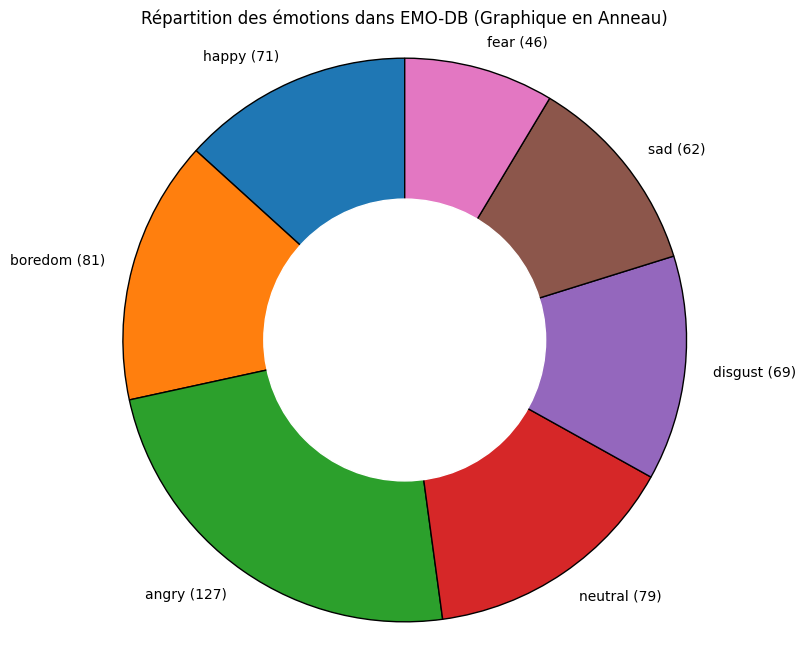

In [ ]:
import os
import matplotlib.pyplot as plt
from collections import Counter

# Dictionnaire des émotions avec les mots demandés
emotion_codes = {
    'N': 'neutral',   # Neutre
    'F': 'happy',     # Joie
    'T': 'sad',       # Tristesse
    'W': 'angry',     # Colère
    'E': 'fear',      # Peur
    'A': 'disgust',   # Dégoût
    'L': 'boredom'    # Ennui (ajouté si nécessaire)
}

# Dossier contenant les fichiers audio
chemin = "/content/drive/MyDrive/EmoDB/wav"  # Remplace par le chemin réel

# Liste pour stocker les émotions trouvées
emotions_found = []

# Parcours des fichiers
for nom_fichier in os.listdir(chemin):
    if nom_fichier.endswith(".wav"):
        emotion_code = nom_fichier[5]  # 6e caractère pour l'émotion
        emotion = emotion_codes.get(emotion_code, "inconnue")
        emotions_found.append(emotion)

# Compte des occurrences de chaque émotion
emotion_counts = Counter(emotions_found)

# Préparation des données pour le graphique
labels = list(emotion_counts.keys())
values = list(emotion_counts.values())

# Création du graphique en anneau
plt.figure(figsize=(8, 8))

# Création des labels avec le nombre d'échantillons
labels_with_counts = [f"{label} ({count})" for label, count in zip(labels, values)]

# Créer le graphique en anneau
plt.pie(values, labels=labels_with_counts, startangle=90, wedgeprops={'edgecolor': 'black', 'linewidth': 1, 'linestyle': 'solid'})

# Ajouter un cercle au centre pour faire un anneau
centre_circle = plt.Circle((0,0), 0.50, color='white', fc='white', linewidth=1)
plt.gca().add_artist(centre_circle)

# Titre
plt.title("Répartition des émotions dans EMO-DB (Graphique en Anneau)")

# Affichage du graphique
plt.axis('equal')  # Pour s'assurer que l'anneau est bien circulaire
plt.show()


# Preparation des données

## 1. Fusion des 2 datasets

Pour augmenter la diversité et le volume des données d’entraînement, nous avons fusionné les datasets RAVDESS et EmoDB en alignant leurs catégories émotionnelles communes. Bien que ces datasets diffèrent par la langue (RAVDESS en anglais, EmoDB en allemand) et les conditions d’enregistrement, ils partagent un ensemble d’émotions communes : neutre, joyeux, triste, en colère, peur et dégoût

In [ ]:
import os
import shutil

# Dictionnaire des émotions pour RAVDESS
emotion_codes = {
    '01': 'neutral',    # Neutre
    '02': 'calm',       # Calme
    '03': 'happy',      # Joie
    '04': 'sad',        # Tristesse
    '05': 'angry',      # Colère
    '06': 'fear',       # Peur
    '07': 'disgust',    # Dégoût
    '08': 'surprise'    # Surprise
}

# Dossier contenant les sous-dossiers des acteurs
chemin = "/content/drive/MyDrive/RAVDESS"  # Remplace par le chemin réel
destination_base = "/content/drive/MyDrive/MERGED_ONE"  # Dossier où les fichiers seront triés

# Crée le dossier de destination de base s'il n'existe pas
if not os.path.exists(destination_base):
    os.makedirs(destination_base)

# Parcours des sous-dossiers (acteurs)
for acteur in os.listdir(chemin):
    acteur_path = os.path.join(chemin, acteur)  # Chemin vers chaque sous-dossier d'acteur
    if os.path.isdir(acteur_path):  # Vérifie si c'est un sous-dossier
        # Parcours des fichiers .wav dans chaque sous-dossier d'acteur
        for nom_fichier in os.listdir(acteur_path):
            if nom_fichier.endswith(".wav"):
                # Les codes des émotions sont généralement dans les 6-7 premiers caractères du nom du fichier
                emotion_code = nom_fichier[6:8]  # Les 2 premiers caractères après l'ID de l'acteur
                emotion = emotion_codes.get(emotion_code, "inconnue")

                # Crée le dossier pour l'émotion si nécessaire
                emotion_folder = os.path.join(destination_base, emotion)
                if not os.path.exists(emotion_folder):
                    os.makedirs(emotion_folder)

                # Déplace le fichier dans le dossier associé à l'émotion
                source_file = os.path.join(acteur_path, nom_fichier)
                destination_file = os.path.join(emotion_folder, nom_fichier)
                shutil.move(source_file, destination_file)

                print(f"Moved: {nom_fichier} to {emotion_folder}")

print("Files have been successfully sorted.")


Moved: 03-01-04-02-01-01-20.wav to /content/drive/MyDrive/MERGED_ONE/sad
Moved: 03-01-03-02-02-02-20.wav to /content/drive/MyDrive/MERGED_ONE/happy
Moved: 03-01-04-01-02-02-20.wav to /content/drive/MyDrive/MERGED_ONE/sad
Moved: 03-01-01-01-02-02-20.wav to /content/drive/MyDrive/MERGED_ONE/neutral
Moved: 03-01-03-01-01-02-20.wav to /content/drive/MyDrive/MERGED_ONE/happy
Moved: 03-01-01-01-02-01-20.wav to /content/drive/MyDrive/MERGED_ONE/neutral
Moved: 03-01-03-01-01-01-20.wav to /content/drive/MyDrive/MERGED_ONE/happy
Moved: 03-01-04-01-01-01-20.wav to /content/drive/MyDrive/MERGED_ONE/sad
Moved: 03-01-02-02-02-02-20.wav to /content/drive/MyDrive/MERGED_ONE/calm
Moved: 03-01-02-02-01-02-20.wav to /content/drive/MyDrive/MERGED_ONE/calm
Moved: 03-01-02-02-01-01-20.wav to /content/drive/MyDrive/MERGED_ONE/calm
Moved: 03-01-02-02-02-01-20.wav to /content/drive/MyDrive/MERGED_ONE/calm
Moved: 03-01-03-02-01-02-20.wav to /content/drive/MyDrive/MERGED_ONE/happy
Moved: 03-01-02-01-02-01-20.wav

In [ ]:
import os
import shutil

# Dictionnaire des émotions pour EMO-DB
emotion_codes_emo_db = {
    'W': 'angry',      # Colère
    'L': 'boredom',    # Ennui
    'E': 'fear',       # Peur
    'A': 'disgust',    # Dégoût
    'F': 'happy',      # Joie
    'T': 'sad',        # Tristesse
    'N': 'neutral'     # Neutre
}

# Dossier contenant les fichiers audio de EMO-DB
chemin_emo_db = "/content/drive/MyDrive/EmoDB/wav"  # Remplace par le chemin réel
destination_base_emo_db = "/content/drive/MyDrive/MERGED_ONE"  # Dossier où les fichiers seront triés

# Crée le dossier de destination de base s'il n'existe pas
if not os.path.exists(destination_base_emo_db):
    os.makedirs(destination_base_emo_db)

# Parcours des fichiers audio dans le dossier EMO-DB
for nom_fichier in os.listdir(chemin_emo_db):
    if nom_fichier.endswith(".wav"):
        # Les codes des émotions sont généralement dans le 6e caractère du nom du fichier
        emotion_code = nom_fichier[5]  # Le code émotionnel se trouve généralement à la position 5
        emotion = emotion_codes_emo_db.get(emotion_code, "inconnue")

        # Crée le dossier pour l'émotion si nécessaire
        emotion_folder = os.path.join(destination_base_emo_db, emotion)
        if not os.path.exists(emotion_folder):
            os.makedirs(emotion_folder)

        # Déplace le fichier dans le dossier associé à l'émotion
        source_file = os.path.join(chemin_emo_db, nom_fichier)
        destination_file = os.path.join(emotion_folder, nom_fichier)
        shutil.move(source_file, destination_file)

        print(f"Moved: {nom_fichier} to {emotion_folder}")

print("Files have been successfully sorted.")


Moved: 08a04Ff.wav to /content/drive/MyDrive/MERGED_ONE/happy
Moved: 03b02La.wav to /content/drive/MyDrive/MERGED_ONE/boredom
Moved: 08a07Wc.wav to /content/drive/MyDrive/MERGED_ONE/angry
Moved: 03a04Lc.wav to /content/drive/MyDrive/MERGED_ONE/boredom
Moved: 03a01Nc.wav to /content/drive/MyDrive/MERGED_ONE/neutral
Moved: 03b03Nb.wav to /content/drive/MyDrive/MERGED_ONE/neutral
Moved: 08b01Aa.wav to /content/drive/MyDrive/MERGED_ONE/disgust
Moved: 03b10Nc.wav to /content/drive/MyDrive/MERGED_ONE/neutral
Moved: 03b09Wa.wav to /content/drive/MyDrive/MERGED_ONE/angry
Moved: 08a02Fe.wav to /content/drive/MyDrive/MERGED_ONE/happy
Moved: 08a07Tb.wav to /content/drive/MyDrive/MERGED_ONE/sad
Moved: 03b01Wc.wav to /content/drive/MyDrive/MERGED_ONE/angry
Moved: 08a01Wc.wav to /content/drive/MyDrive/MERGED_ONE/angry
Moved: 03a05Wb.wav to /content/drive/MyDrive/MERGED_ONE/angry
Moved: 08a04Wc.wav to /content/drive/MyDrive/MERGED_ONE/angry
Moved: 08a07La.wav to /content/drive/MyDrive/MERGED_ONE/bore

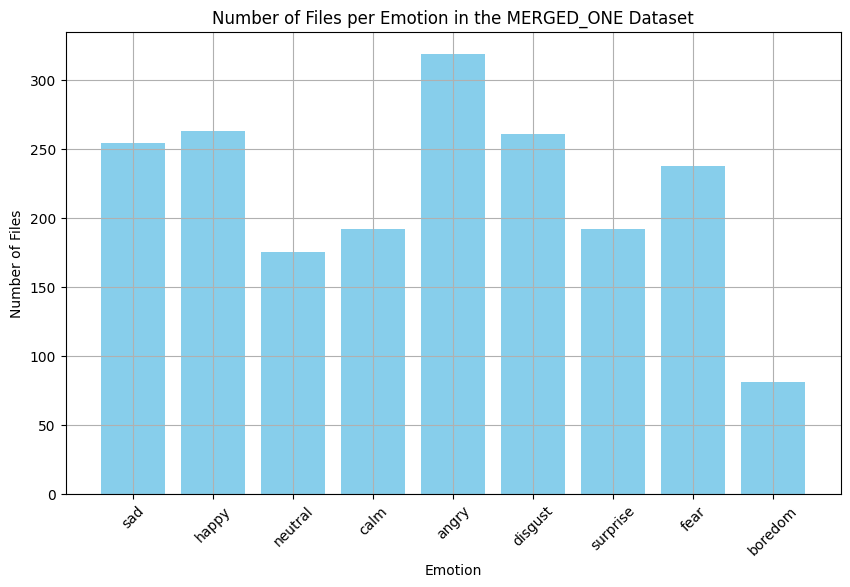

In [ ]:
import os
import matplotlib.pyplot as plt

# Dossier contenant les sous-dossiers d'émotions dans MERGED_ONE
destination_base_emo_db = "/content/drive/MyDrive/MERGED_ONE"

# Dictionnaire pour stocker le nombre de fichiers pour chaque émotion
emotion_counts = {}

# Parcours des sous-dossiers d'émotions dans le dossier MERGED_ONE
for emotion_folder in os.listdir(destination_base_emo_db):
    emotion_path = os.path.join(destination_base_emo_db, emotion_folder)
    if os.path.isdir(emotion_path):
        # Compte le nombre de fichiers .wav dans chaque sous-dossier d'émotion
        num_files = len([f for f in os.listdir(emotion_path) if f.endswith(".wav")])
        emotion_counts[emotion_folder] = num_files

# Visualisation des résultats
plt.figure(figsize=(10, 6))
plt.bar(emotion_counts.keys(), emotion_counts.values(), color='skyblue')
plt.xlabel('Emotion')
plt.ylabel('Number of Files')
plt.title('Number of Files per Emotion in the MERGED_ONE Dataset')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


## Pretrainement des données



*   EmoDB a une fréquence d’échantillonnage de 16 kHz et RAVDESS de 48 kHz,nous avons donc rééchantillonné les deux datasets à 22 025 Hz.
*   Nous avons ajusté la durée des échantillons vocaux exprimant les émotions en complétant par du padding les fichiers les plus courts pour correspondre à la longueur du plus long, afin que toutes les données aient une durée uniforme de 10 secondes.
* Enfin, nous avons regroupé et réorganisé les datasets selon chaque émotion.

Toutes les données audio ont été converties en mél-spectrogrammes grâce à la bibliothèque Python librosa : le signal est traité comme une image, où du bruit est injecté pendant le processus de diffusion et d’inversion, puis retiré.

Pour éviter la perte d’informations temporelles, nous n’avons pas utilisé la Transformée de Fourier Rapide (FFT), mais plutôt la Transformée de Fourier à court terme (STFT) lors de la conversion.

Nous avons choisi un pas de saut (hop length) de 256 et une taille de fenêtre (window size) de 1024 pour la STFT.

Une normalisation par Z-score a été appliquée pour la standardisation des données.

##Génération et sauvegarde de mél-spectrogrammes normalisés Z-score à partir de fichiers audio catégorisés par émotions

In [ ]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import gc  # Module pour forcer le nettoyage de la mémoire

# Chemin d'entrée et de sortie
input_root = "/content/drive/MyDrive/MERGED_ONE"
output_root = "/content/drive/MyDrive/MelSpectrograms_MERGED_ONE"

# Liste des émotions à traiter
target_emotions = ["sad", "happy", "angry", "fear", "disgust", "neutral"]

# Paramètres audio
duration_sec = 10
target_sr = 22025
target_length = duration_sec * target_sr

for emotion in target_emotions:
    emotion_path = os.path.join(input_root, emotion)

    if os.path.isdir(emotion_path):
        output_emotion_path = os.path.join(output_root, emotion)
        os.makedirs(output_emotion_path, exist_ok=True)

        for filename in os.listdir(emotion_path):
            if filename.endswith(".wav"):
                file_path = os.path.join(emotion_path, filename)
                output_img_path = os.path.join(output_emotion_path, f"{os.path.splitext(filename)[0]}.png")

                # Charger l'audio
                audio, sr = librosa.load(file_path, sr=target_sr)
                audio, _ = librosa.effects.trim(audio)

                # Centrage sur 6s
                if len(audio) < target_length:
                    padding_total = target_length - len(audio)
                    pad_left = padding_total // 2
                    pad_right = padding_total - pad_left
                    audio = np.pad(audio, (pad_left, pad_right), mode='constant')
                else:
                    audio = audio[:target_length]

                # Mél-spectrogramme
                mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=1024,
                                                          hop_length=256, win_length=1024, n_mels=128)
                mel_db = librosa.power_to_db(mel_spec, ref=np.max)

                # Normalisation Z-score
                mean = np.mean(mel_db)
                std = np.std(mel_db)
                mel_db = (mel_db - mean) / std

                # Sauvegarde de l'image
                plt.figure(figsize=(10, 4))
                librosa.display.specshow(mel_db, sr=sr, hop_length=256, x_axis='time', y_axis='mel', cmap='magma')
                plt.colorbar(label='Z-score (dB)')
                plt.tight_layout()
                plt.savefig(output_img_path)
                plt.close()  # Fermeture de la figure pour libérer la mémoire

                # Nettoyage explicite de la mémoire
                del mel_spec, mel_db, audio  # Supprimer les variables qui ne sont plus nécessaires
                gc.collect()  # Libérer la mémoire inutilisée

        print(f"Les mél-spectrogrammes normalisés pour '{emotion}' ont été générés et sauvegardés.")
    else:
        print(f"Le dossier '{emotion}' n'existe pas dans {input_root}.")


Les mél-spectrogrammes normalisés pour 'sad' ont été générés et sauvegardés.
Les mél-spectrogrammes normalisés pour 'happy' ont été générés et sauvegardés.
Les mél-spectrogrammes normalisés pour 'angry' ont été générés et sauvegardés.
Les mél-spectrogrammes normalisés pour 'fear' ont été générés et sauvegardés.
Les mél-spectrogrammes normalisés pour 'disgust' ont été générés et sauvegardés.


In [ ]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import gc  # Module pour forcer le nettoyage de la mémoire

# Chemin d'entrée et de sortie
input_root = "/content/drive/MyDrive/MERGED_ONE"
output_root = "/content/drive/MyDrive/MelSpectrograms_MERGED_ONE"

# Liste des émotions à traiter
target_emotions = [ "neutral"]

# Paramètres audio
duration_sec = 10
target_sr = 22025
target_length = duration_sec * target_sr

for emotion in target_emotions:
    emotion_path = os.path.join(input_root, emotion)

    if os.path.isdir(emotion_path):
        output_emotion_path = os.path.join(output_root, emotion)
        os.makedirs(output_emotion_path, exist_ok=True)

        for filename in os.listdir(emotion_path):
            if filename.endswith(".wav"):
                file_path = os.path.join(emotion_path, filename)
                output_img_path = os.path.join(output_emotion_path, f"{os.path.splitext(filename)[0]}.png")

                # Charger l'audio
                audio, sr = librosa.load(file_path, sr=target_sr)
                audio, _ = librosa.effects.trim(audio)

                # Centrage sur 6s
                if len(audio) < target_length:
                    padding_total = target_length - len(audio)
                    pad_left = padding_total // 2
                    pad_right = padding_total - pad_left
                    audio = np.pad(audio, (pad_left, pad_right), mode='constant')
                else:
                    audio = audio[:target_length]

                # Mél-spectrogramme
                mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=1024,
                                                          hop_length=256, win_length=1024, n_mels=128)
                mel_db = librosa.power_to_db(mel_spec, ref=np.max)

                # Normalisation Z-score
                mean = np.mean(mel_db)
                std = np.std(mel_db)
                mel_db = (mel_db - mean) / std

                # Sauvegarde de l'image
                plt.figure(figsize=(10, 4))
                librosa.display.specshow(mel_db, sr=sr, hop_length=256, x_axis='time', y_axis='mel', cmap='magma')
                plt.colorbar(label='Z-score (dB)')
                plt.tight_layout()
                plt.savefig(output_img_path)
                plt.close()  # Fermeture de la figure pour libérer la mémoire

                # Nettoyage explicite de la mémoire
                del mel_spec, mel_db, audio  # Supprimer les variables qui ne sont plus nécessaires
                gc.collect()  # Libérer la mémoire inutilisée

        print(f"Les mél-spectrogrammes normalisés pour '{emotion}' ont été générés et sauvegardés.")
    else:
        print(f"Le dossier '{emotion}' n'existe pas dans {input_root}.")


Les mél-spectrogrammes normalisés pour 'neutral' ont été générés et sauvegardés.


**Mel-spectrogram visualization**

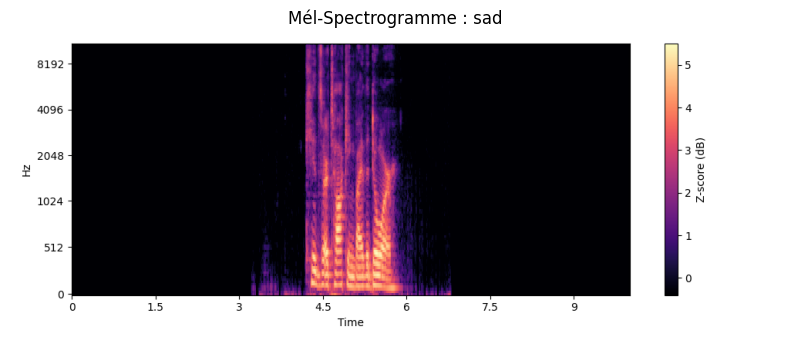

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# Exemple : afficher une image générée pour l’émotion "sad"
emotion = "sad"
base_path = "/content/drive/MyDrive/MelSpectrograms_MERGED_ONE"
image_name = "03-01-04-01-01-01-13.png"  # Remplace ce nom par l'un de ceux générés chez toi

# Chemin complet vers l'image
img_path = os.path.join(base_path, emotion, image_name)

# Vérifier que le fichier existe
if os.path.isfile(img_path):
    # Lire et afficher l'image
    img = mpimg.imread(img_path)
    plt.figure(figsize=(10, 4))
    plt.imshow(img)
    plt.title(f"Mél-Spectrogramme : {emotion}")
    plt.axis('off')
    plt.show()
else:
    print(f"Le fichier {img_path} n'existe pas.")


# Modelisation

## Resnet50

**Génération d’Embeddings d’Émotion :**
1. Les informations émotionnelles ont été extraites à partir d’énoncés typiques en utilisant des mél-spectrogrammes comme caractéristiques d’entrée. Ces spectrogrammes codent les caractéristiques fréquentielles de la parole, essentielles pour la détection des émotions.



2. Modèle de Classification des Émotions :
Un modèle ResNet-50, implémenté avec PyTorch, a été utilisé pour réaliser la classification. ResNet-50 est un réseau de neurones convolutionnel profond (CNN) particulièrement adapté à l’extraction hiérarchique des caractéristiques audio.

**Les données d’entraînement et de validation ont été divisées selon un ratio 80/20 pour l’entraînement.**

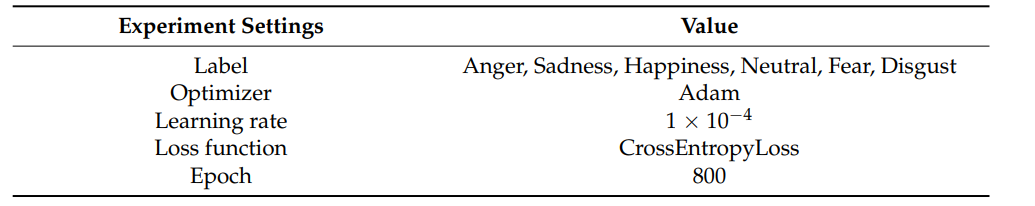

##Extraction des vecteurs d’émotion à partir des mél-spectrogrammes avec un modèle ResNet50 et entraînement d’un classifieur d’émotions vocales

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 54.9MB/s]


[1/40] Loss: 1.7345 | Val Loss: 2.3049 | Val Acc: 0.1854 | F1: 0.0959
✅ Meilleur modèle sauvegardé.
[2/40] Loss: 1.1824 | Val Loss: 1.3772 | Val Acc: 0.4702 | F1: 0.4497
✅ Meilleur modèle sauvegardé.
[3/40] Loss: 0.7822 | Val Loss: 1.8494 | Val Acc: 0.4901 | F1: 0.4755
[4/40] Loss: 0.4706 | Val Loss: 1.3865 | Val Acc: 0.5695 | F1: 0.5657
[5/40] Loss: 0.2948 | Val Loss: 1.3180 | Val Acc: 0.6093 | F1: 0.6044
✅ Meilleur modèle sauvegardé.
[6/40] Loss: 0.1869 | Val Loss: 1.5683 | Val Acc: 0.5728 | F1: 0.5513
[7/40] Loss: 0.1453 | Val Loss: 1.4975 | Val Acc: 0.6159 | F1: 0.6099
[8/40] Loss: 0.1615 | Val Loss: 2.0580 | Val Acc: 0.5861 | F1: 0.5880
[9/40] Loss: 0.1199 | Val Loss: 1.8254 | Val Acc: 0.5728 | F1: 0.5692
[10/40] Loss: 0.1050 | Val Loss: 1.4903 | Val Acc: 0.6490 | F1: 0.6424
Early stopping déclenché. Arrêt de l'entraînement.


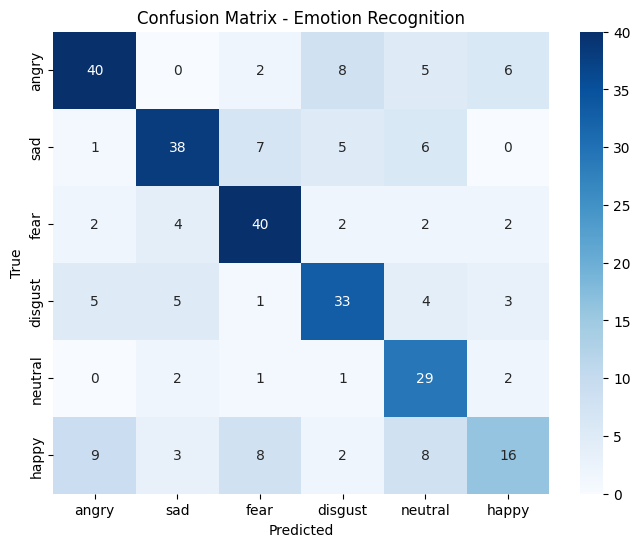


✅ Fichier CSV 'emotion_vectors.csv' généré avec 1510 vecteurs.


In [ ]:
import os
import csv
import torch
import torch.nn as nn
from torchvision import models, datasets, transforms
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Dictionnaire des émotions
emotion_to_index = {
    "angry": 0,
    "sad": 1,
    "fear": 2,
    "disgust": 3,
    "neutral": 4,
    "happy": 5
}

# Dataset personnalisé
class SpectrogramDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []

        for emotion in os.listdir(root_dir):
            emotion_path = os.path.join(root_dir, emotion)
            if os.path.isdir(emotion_path):
                for fname in os.listdir(emotion_path):
                    if fname.endswith(".png"):
                        self.samples.append((os.path.join(emotion_path, fname), emotion_to_index[emotion]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("L")
        if self.transform:
            image = self.transform(image)
        return image, label

# Modèle SER basé sur ResNet50
class SERResNet50(nn.Module):
    def __init__(self, num_classes=6):
        super(SERResNet50, self).__init__()
        self.base_model = models.resnet50(pretrained=True)
        self.base_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        in_features = self.base_model.fc.in_features

        self.feature_extractor = nn.Sequential(*list(self.base_model.children())[:-1])
        self.classifier = nn.Sequential(
            nn.BatchNorm1d(in_features),
            nn.Dropout(0.5),  # Dropout ajouté pour éviter le sur-apprentissage
            nn.Linear(in_features, num_classes)
        )

    def forward(self, x):
        features = self.feature_extractor(x).squeeze()
        logits = self.classifier(features)
        return logits

    def extract_features(self, x):
        with torch.no_grad():
            features = self.feature_extractor(x).squeeze()
        return features

# Préparation des données
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

dataset = SpectrogramDataset("/content/drive/MyDrive/MelSpectrograms_MERGED_ONE", transform=transform)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# Initialisation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SERResNet50(num_classes=6).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Early Stopping Initialization
best_val_loss = float('inf')
patience = 5  # Nombre d'époques sans amélioration
patience_counter = 0

# Entraînement
for epoch in range(1, 41):
    model.train()
    total_loss = 0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Validation
    model.eval()
    all_preds, all_labels = [], []
    val_loss = 0
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            outputs = model(x_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_val.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f"[{epoch}/40] Loss: {total_loss / len(train_loader):.4f} | Val Loss: {val_loss / len(val_loader):.4f} | Val Acc: {acc:.4f} | F1: {f1:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Sauvegarder le modèle avec la meilleure performance de validation
        torch.save(model.state_dict(), "/content/drive/MyDrive/emotion_recognition_best_model.pth")
        print("✅ Meilleur modèle sauvegardé.")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping déclenché. Arrêt de l'entraînement.")
            break

# Matrice de confusion
cm = confusion_matrix(all_labels, all_preds)
labels = list(emotion_to_index.keys())
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Emotion Recognition")
plt.show()

# ✅ Exporter les emotion vectors dans un CSV
output_csv = "emotion_vectors.csv"
model.eval()

with open(output_csv, mode='w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['filepath', 'emotion_vector'])  # en-têtes

    for img_path, label in dataset.samples:
        image = Image.open(img_path).convert("L")
        image = transform(image).unsqueeze(0).to(device)
        vector = model.extract_features(image).cpu().numpy()  # (2048,)
        vector_str = " ".join(map(str, vector))
        writer.writerow([img_path, vector_str])

print(f"\n✅ Fichier CSV 'emotion_vectors.csv' généré avec {len(dataset)} vecteurs.")


##Extraction et sauvegarde des vecteurs d’émotion depuis les mél-spectrogrammes à l’aide du modèle pré-entraîné ResNet50

In [ ]:
import os
import csv
import torch
from PIL import Image
from torchvision import transforms

# Charger le modèle
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Définir le modèle (assurez-vous que la classe SERResNet50 est définie avant d'exécuter ce code)
model = SERResNet50(num_classes=6).to(device)
model.load_state_dict(torch.load("/content/drive_new/MyDrive/emotion_recognition_best_model.pth"))
model.eval()

# Préparation des données et transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Charger les spectrogrammes (ici on suppose que le chemin est correct pour vos spectrogrammes)
mel_dir = "/content/drive_new/MyDrive/MelSpectrograms_MERGED_ONE"  # Mettez à jour ce chemin selon l'emplacement de vos images

# Liste pour stocker les embeddings des émotions
data = []

# Passer à travers les spectrogrammes et extraire les embeddings
with torch.no_grad():
    for emotion in os.listdir(mel_dir):
        emotion_path = os.path.join(mel_dir, emotion)
        if not os.path.isdir(emotion_path):
            continue
        for fname in os.listdir(emotion_path):
            if fname.endswith(".png"):
                img_path = os.path.join(emotion_path, fname)

                # Charger l'image et appliquer la transformation
                image = Image.open(img_path).convert("L")
                tensor = transform(image).unsqueeze(0).to(device)

                # Extraire les embeddings
                vector = model.extract_features(tensor).cpu().numpy()  # (2048,)

                # Ajouter les données
                data.append({
                    "filepath": img_path,
                    "emotion_vector": vector.tolist()
                })

# Sauvegarder les résultats dans un fichier CSV
output_csv = "/content/drive_new/MyDrive/emotion_vectors.csv"
with open(output_csv, mode='w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['filepath', 'emotion_vector'])  # En-têtes du CSV

    # Écrire les lignes avec le chemin et l'embedding
    for row in data:
        writer.writerow([row["filepath"], " ".join(map(str, row["emotion_vector"]))])

print(f"\n✅ Fichier CSV 'emotion_vectors.csv' généré avec {len(data)} vecteurs.")



✅ Fichier CSV 'emotion_vectors.csv' généré avec 1510 vecteurs.


- Pour chaque mél-spectrogramme, nous avons sauvegardé son chemin de fichier ainsi que le vecteur d’embedding émotionnel correspondant dans un fichier CSV.

- Les scores finaux (une précision d’environ 64 % et un F1 d’environ 64 %) indiquent que le modèle montre une performance correcte avec une capacité de généralisation acceptable sur les données de validation.


## Mel-style encodeur


* Encodeur de style audio basé sur ResNet avec attention.

* Extrait un vecteur de style des mél-spectrogrammes grâce à des blocs résiduels et des couches d'attention, capturant les caractéristiques importantes du signal.



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.skip = nn.Sequential()
        if in_channels != out_channels or stride != 1:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.skip(x)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        return F.relu(out)

class SelfAttention(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.query = nn.Conv1d(in_dim, in_dim // 8, kernel_size=1)
        self.key = nn.Conv1d(in_dim, in_dim // 8, kernel_size=1)
        self.value = nn.Conv1d(in_dim, in_dim, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        # x: (B, C, H, W)
        B, C, H, W = x.shape
        x_flat = x.view(B, C, -1)  # (B, C, H*W)
        Q = self.query(x_flat)     # (B, C//8, H*W)
        K = self.key(x_flat)       # (B, C//8, H*W)
        V = self.value(x_flat)     # (B, C, H*W)

        attention = torch.bmm(Q.permute(0, 2, 1), K)  # (B, H*W, H*W)
        attention = F.softmax(attention, dim=-1)
        out = torch.bmm(V, attention)  # (B, C, H*W)
        out = out.view(B, C, H, W)

        return self.gamma * out + x

class MelStyleEncoder(nn.Module):
    def __init__(self, output_dim=128):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
        self.block1 = ResNetBlock(64, 128)
        self.attn1 = SelfAttention(128)
        self.block2 = ResNetBlock(128, 256)
        self.attn2 = SelfAttention(256)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, output_dim)  # vecteur de style final

    def forward(self, x):
        x = F.relu(self.conv1(x))       # (B, 64, H, W)
        x = self.block1(x)              # (B, 128, H, W)
        x = self.attn1(x)               # (B, 128, H, W)
        x = self.block2(x)              # (B, 256, H, W)
        x = self.attn2(x)               # (B, 256, H, W)
        x = self.pool(x).squeeze(-1).squeeze(-1)  # (B, 256)
        return self.fc(x)               # (B, output_dim)




* Extraction des vecteurs de style audio à partir des mél-spectrogrammes.

* Le modèle MelStyleEncoder génère un vecteur de style 128D pour chaque image,
puis les vecteurs et leurs chemins sont sauvegardés dans un fichier CSV.



In [ ]:
import os
import torch
import pandas as pd
from PIL import Image
from torchvision import transforms

# Chemin vers les images
mel_dir = "/content/drive_new/MyDrive/MelSpectrograms_MERGED_ONE"
model = MelStyleEncoder(output_dim=128).to("cpu")
model.eval()

# Transformation
transform = transforms.Compose([
    transforms.Resize((64, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Liste pour stocker les données
data = []

with torch.no_grad():
    for emotion in os.listdir(mel_dir):
        emotion_path = os.path.join(mel_dir, emotion)
        if not os.path.isdir(emotion_path):
            continue
        for fname in os.listdir(emotion_path):
            if fname.endswith(".png"):
                img_path = os.path.join(emotion_path, fname)
                image = Image.open(img_path).convert("L")
                tensor = transform(image).unsqueeze(0)
                vec = model(tensor).squeeze().numpy()
                data.append({
                    "path": img_path,
                    "vector": vec.tolist()
                })

# Spécifier l'emplacement dans Google Drive
output_dir = "/content/drive/MyDrive/mel_style_vectors"  # Change ceci pour le dossier voulu sur ton Drive
os.makedirs(output_dir, exist_ok=True)  # Créer le dossier si il n'existe pas

# Sauvegarder en CSV dans Google Drive
output_csv = os.path.join(output_dir, "mel_style_vectors.csv")
df = pd.DataFrame(data)
df.to_csv(output_csv, index=False)

print(f"✅ CSV sauvegardé dans {output_csv}.")


✅ CSV sauvegardé dans /content/drive_new/MyDrive/mel_style_vectors/mel_style_vectors.csv.


**Exemple d'un Mel-style vecteur**

In [ ]:
from PIL import Image
from PIL import Image
import torch
from torchvision import transforms


transform = transforms.Compose([
    transforms.Resize((64, 128)),  # ⬅️ taille réduite (au lieu de 128x862)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])
# Charger une image mél-spectrogramme
image_path = "/content/drive_new/MyDrive/MelSpectrograms_MERGED_ONE/angry/03-01-05-01-01-01-01.png"
image = Image.open(image_path).convert("L")
mel_tensor = transform(image).unsqueeze(0)  # (1, 1, 64, 128)

# Créer le modèle
model = MelStyleEncoder(output_dim=128).to("cpu")  # ou "cuda" si tu veux tester sur GPU
model.eval()

# Extraire le vecteur
with torch.no_grad():
    vec = model(mel_tensor)
    print("✅ Vecteur de style (shape):", vec.shape)
    print(vec)


✅ Vecteur de style (shape): torch.Size([1, 128])
tensor([[ 0.0378,  0.0398,  0.0133, -0.0872,  0.0688,  0.0062, -0.0314, -0.0125,
          0.0560,  0.0258, -0.0490, -0.1542,  0.0646,  0.0910,  0.0081, -0.0714,
          0.0658, -0.0415, -0.0680,  0.0037, -0.0039, -0.1099,  0.0650, -0.0472,
          0.0585, -0.0409, -0.0175, -0.0783,  0.0679,  0.0786,  0.0495,  0.0351,
         -0.0273,  0.0262,  0.0145,  0.0411,  0.0096, -0.0095,  0.0303, -0.0020,
          0.1309, -0.0703,  0.1732, -0.0254,  0.0864,  0.0027,  0.0553, -0.0200,
          0.0512, -0.0517, -0.0060,  0.0045, -0.0493,  0.1201, -0.0296, -0.0877,
         -0.0149, -0.0260, -0.0020,  0.0875,  0.0318,  0.0169, -0.0223,  0.0372,
         -0.0213, -0.0208,  0.0608, -0.0707, -0.0068,  0.0777,  0.1324,  0.0011,
         -0.0226,  0.0351, -0.0777, -0.0017,  0.0516, -0.0769, -0.0559, -0.0414,
         -0.1342,  0.0421, -0.0428, -0.0105, -0.0363,  0.0871,  0.0268,  0.0945,
         -0.0197,  0.0606,  0.0216,  0.0267,  0.0284, -0.032

## Entrée Conditionnelle


* Ajout d’une description textuelle des émotions aux vecteurs de style audio.

* On extrait l’émotion depuis le chemin du fichier, puis on associe un textedécrivant chaque émotion. Le résultat est sauvegardé dans un nouveau fichier CSV.



In [ ]:
import pandas as pd

# Charger le CSV d'origine
df = pd.read_csv('/content/drive_new/MyDrive/mel_style_vectors/mel_style_vectors.csv')

# Dictionnaire pour associer les émotions à leur description textuelle
emotion_to_text = {
    "angry": "A person speaking with irritation and frustration",
    "happy": "An utterance filled with joy and excitement",
    "sad": "A voice expressing sorrow or melancholy",
    "fear": "An anxious or worried tone, as if afraid",
    "disgust": "A tone reflecting revulsion or distaste",
    "neutral": "A voice without strong emotional expression, plain and factual."
}

# Fonction pour extraire l'émotion depuis le chemin du fichier
def extract_emotion(path):
    return path.split('/')[-2]  # récupère l'avant-dernier élément du chemin

# Appliquer la fonction pour créer la colonne 'emotion'
df['emotion'] = df['path'].apply(extract_emotion)

# Associer le text condition depuis le dictionnaire
df['text_condition'] = df['emotion'].map(emotion_to_text)

# Renommer la colonne 'path' en 'filepath'
df.rename(columns={'path': 'filepath'}, inplace=True)

# Sauvegarder la nouvelle copie du CSV
df.to_csv('/content/drive_new/MyDrive/mel_style_vectors_text_conditions.csv', index=False)

print("✅ Fichier mis à jour avec succès !")

✅ Fichier mis à jour avec succès !


In [ ]:
df1 = pd.read_csv('/content/drive_new/MyDrive/mel_style_vectors_text_conditions.csv')
df1.head()

,filepath,vector,emotion,text_condition
0,/content/drive_new/MyDrive/MelSpectrograms_MER...,"[-0.07511784136295319, 0.059011317789554596, -...",sad,A voice expressing sorrow or melancholy
1,/content/drive_new/MyDrive/MelSpectrograms_MER...,"[-0.07363061606884003, 0.05730997771024704, -0...",sad,A voice expressing sorrow or melancholy
2,/content/drive_new/MyDrive/MelSpectrograms_MER...,"[-0.07262888550758362, 0.05643601715564728, -0...",sad,A voice expressing sorrow or melancholy
3,/content/drive_new/MyDrive/MelSpectrograms_MER...,"[-0.07364119589328766, 0.05760890245437622, -0...",sad,A voice expressing sorrow or melancholy
4,/content/drive_new/MyDrive/MelSpectrograms_MER...,"[-0.07438206672668457, 0.05805334448814392, -0...",sad,A voice expressing sorrow or melancholy


##Encodage des descriptions émotionnelles avec BERT

* Ce code convertit les descriptions textuelles des émotions en vecteurs numériques grâce au modèle BERT, pour enrichir les données utilisées dans le projet. Les résultats sont sauvegardés dans un fichier CSV.

In [ ]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertModel
from tqdm import tqdm

# Charger le CSV enrichi avec text_condition
df = pd.read_csv('/content/drive_new/MyDrive/mel_style_vectors_text_conditions.csv')

# Charger BERT (tokenizer + modèle)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
model.eval()

# Désactiver le calcul de gradient (plus rapide)
@torch.no_grad()
def get_text_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
    outputs = model(**inputs)
    # Moyenne sur les tokens
    embedding = outputs.last_hidden_state.mean(dim=1).squeeze().tolist()  # liste de floats
    return embedding

# Encodage BERT pour chaque ligne
tqdm.pandas()  # pour barre de progression
df['text_embedding'] = df['text_condition'].progress_apply(get_text_embedding)

# Sauvegarder le résultat final
df.to_csv('/content/drive_new/MyDrive/mel_style_vectors_text_embedded.csv', index=False)

print("✅ Fichier final sauvegardé avec les embeddings BERT !")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

100%|██████████| 1510/1510 [02:59<00:00,  8.43it/s]


✅ Fichier final sauvegardé avec les embeddings BERT !


## Modele de Diffusion

* Le modèle de diffusion est un modèle d’IA générative qui produit des mél-spectrogrammes à partir des entrées conditionnelles de l’utilisateur : vecteur de style mél, vecteur d’émotion et bruit.

* Le processus de génération consiste à injecter puis extraire le bruit pour créer les résultats demandés par l’utilisateur.

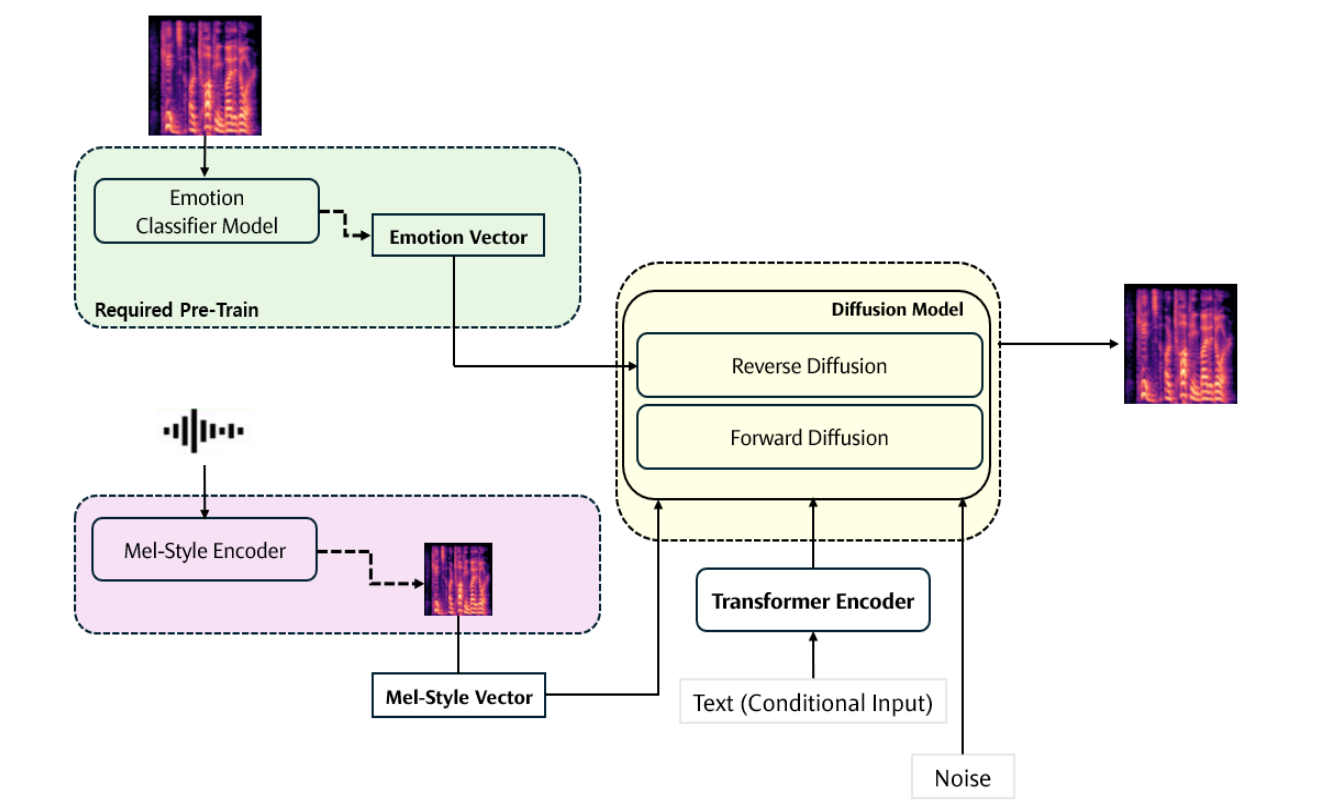

###Entraînement d'un modèle Diffusion U-Net avec sauvegarde de checkpoints et génération de mél-spectrogrammes

Epoch 1/50, Loss: 0.2057676060056245
Epoch 2/50, Loss: 0.06045342772883713
Epoch 3/50, Loss: 0.04298879926600469
Epoch 4/50, Loss: 0.03600318706224835
Epoch 5/50, Loss: 0.03154912354454162
Epoch 6/50, Loss: 0.02987239439355791
Epoch 7/50, Loss: 0.02960584346678049
Epoch 8/50, Loss: 0.028260034075371487
Epoch 9/50, Loss: 0.024097349903689176
Epoch 10/50, Loss: 0.024572632566252084
Epoch 11/50, Loss: 0.02550538288301261
Epoch 12/50, Loss: 0.02230499789276451
Epoch 13/50, Loss: 0.01946399265299083
Epoch 14/50, Loss: 0.021904763519251472
Epoch 15/50, Loss: 0.022726599651847094
Epoch 16/50, Loss: 0.01922706384753818
Epoch 17/50, Loss: 0.019253774762902624
Epoch 18/50, Loss: 0.018397813357373394
Epoch 19/50, Loss: 0.01950212782150302
Epoch 20/50, Loss: 0.019956535886401536
Epoch 21/50, Loss: 0.018058929883101316
Epoch 22/50, Loss: 0.018292332962451
Epoch 23/50, Loss: 0.017217028378533623
Epoch 24/50, Loss: 0.01719724869345704
Epoch 25/50, Loss: 0.016511536964644042
Epoch 26/50, Loss: 0.01564

ValueError: For X (81) and Y (2) with flat shading, A should have shape (1, 80, 3) or (1, 80, 4) or (1, 80) or (80,), not (1, 80, 861)

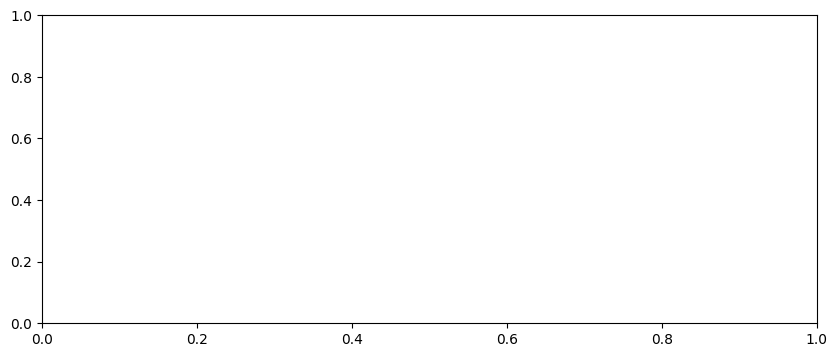

In [7]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import pandas as pd
import numpy as np
from ast import literal_eval
from PIL import Image
import matplotlib.pyplot as plt
import librosa.display
from torchvision import transforms
from torch.amp import autocast, GradScaler  # Updated import

# Set expandable segments to reduce memory fragmentation
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Sinusoidal Position Embeddings for Time Steps
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, embedding_dim):
        super().__init__()
        self.embedding_dim = embedding_dim

    def forward(self, timesteps):
        half_dim = self.embedding_dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=timesteps.device) * -emb)
        emb = timesteps[:, None] * emb[None, :]
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)
        return emb

# ResNet Block
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.skip = nn.Sequential()
        if in_channels != out_channels or stride != 1:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.skip(x)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        return F.relu(out)

# Condition Projector
class ConditionProjector(nn.Module):
    def __init__(self, input_dim, target_dim):
        super().__init__()
        self.fc = nn.Linear(input_dim, target_dim)
        self.act = nn.ReLU()

    def forward(self, x):
        return self.act(self.fc(x))

# Diffusion U-Net Model (Corrected)
class DiffusionUNet(nn.Module):
    def __init__(self, cond_dim=768, mel_style_dim=128, emotion_dim=2048, time_emb_dim=128):
        super().__init__()
        self.time_embed = SinusoidalPositionEmbeddings(time_emb_dim)
        self.fc_time = nn.Linear(time_emb_dim, 128)

        self.fc_mel_style = ConditionProjector(mel_style_dim, 128)
        self.fc_text = ConditionProjector(cond_dim, 128)
        self.fc_emotion = ConditionProjector(emotion_dim, 128)

        self.input_conv = nn.Conv2d(1, 128, kernel_size=3, padding=1)  # [B, 1, 80, 861] -> [B, 128, 80, 861]

        # Downsampling path
        self.res1 = ResNetBlock(128, 128, stride=1)  # [B, 128, 80, 861]
        self.down1 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)  # [B, 256, 40, 430]
        self.res2 = ResNetBlock(256, 512, stride=1)  # [B, 512, 40, 430]

        # Upsampling path
        self.up1 = nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, output_padding=(0, 1))  # [B, 256, 80, 861]
        self.res3 = ResNetBlock(256, 256, stride=1)  # [B, 256, 80, 861]
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=1, padding=1)  # [B, 128, 80, 861]
        self.res4 = ResNetBlock(128, 128, stride=1)  # [B, 128, 80, 861]

        self.out_conv = nn.Conv2d(128, 1, kernel_size=3, padding=1)  # [B, 1, 80, 861]

    def forward(self, x, t, mel_style_vector, text_vector, emotion_vector=None, reverse_phase=False):
        t_emb = self.fc_time(self.time_embed(t))
        mel_style_emb = self.fc_mel_style(mel_style_vector)
        text_emb = self.fc_text(text_vector)

        if reverse_phase and emotion_vector is not None:
            emotion_emb = self.fc_emotion(emotion_vector)
            global_emb = t_emb + mel_style_emb + text_emb + emotion_emb
        else:
            global_emb = t_emb + mel_style_emb + text_emb

        global_emb = global_emb[:, :, None, None]
        h = self.input_conv(x)
        h = h + global_emb

        h = self.res1(h)
        h = self.down1(h)
        h = self.res2(h)
        h = self.up1(h)
        h = self.res3(h)
        h = self.up2(h)
        h = self.res4(h)
        out = self.out_conv(h)
        return out

# Forward Diffusion Process
def forward_diffusion_sample(x0, t, betas):
    noise = torch.randn_like(x0)
    sqrt_alpha_cumprod = torch.sqrt(torch.cumprod(1.0 - betas, dim=0)).to(x0.device)
    sqrt_one_minus_alpha_cumprod = torch.sqrt(1.0 - torch.cumprod(1.0 - betas, dim=0)).to(x0.device)
    xt = sqrt_alpha_cumprod[t][:, None, None, None] * x0 + sqrt_one_minus_alpha_cumprod[t][:, None, None, None] * noise
    return xt, noise

# Beta Schedule
def make_beta_schedule(T=1000, start=1e-4, end=0.02):
    return torch.linspace(start, end, T)

# Reverse Diffusion Sampling
def reverse_diffusion_sample(model, x_t, t, mel_style_vector, text_vector, emotion_vector, betas, T, device):
    model.eval()
    with torch.no_grad():
        for i in reversed(range(0, t)):
            t_tensor = torch.full((x_t.shape[0],), i, dtype=torch.long, device=device)
            with autocast('cuda'):  # Updated to torch.amp
                predicted_noise = model(x_t, t_tensor, mel_style_vector, text_vector, emotion_vector, reverse_phase=True)
            alpha = 1.0 - betas[i]
            alpha_cumprod = torch.cumprod(1.0 - betas[:i+1], dim=0)[-1]
            x_t = (1.0 / torch.sqrt(alpha)) * (x_t - ((1.0 - alpha) / torch.sqrt(1.0 - alpha_cumprod)) * predicted_noise)
            if i > 0:
                x_t += torch.sqrt(betas[i]) * torch.randn_like(x_t)
    return x_t

# Load Data
def load_data(mel_style_csv, emotion_csv, mel_spectrogram_dir, save_tensors=True):
    mel_df = pd.read_csv(mel_style_csv)
    mel_df['vector'] = mel_df['vector'].apply(literal_eval)
    mel_df['text_embedding'] = mel_df['text_embedding'].apply(literal_eval)

    emotion_df = pd.read_csv(emotion_csv)
    emotion_df['emotion_vector'] = emotion_df['emotion_vector'].apply(lambda x: list(map(float, x.split())))

    mel_spectrograms = []
    transform = transforms.Compose([
        transforms.Resize((80, 861)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])

    for path in mel_df['filepath'].tolist():
        pt_path = path.replace('.png', '.pt')
        if os.path.exists(pt_path):
            mel_tensor = torch.load(pt_path, map_location='cpu')
        else:
            image = Image.open(path).convert("L")
            mel_tensor = transform(image)
            if save_tensors:
                torch.save(mel_tensor, pt_path)
        mel_spectrograms.append(mel_tensor)

    mel_spectrograms = torch.stack(mel_spectrograms)
    mel_style_vectors = torch.tensor(mel_df['vector'].tolist())
    text_embeddings = torch.tensor(mel_df['text_embedding'].tolist())
    emotion_vectors = torch.tensor(emotion_df['emotion_vector'].tolist())

    return mel_spectrograms, mel_style_vectors, text_embeddings, emotion_vectors

# Training Loop with Mixed Precision and Gradient Accumulation
def train_diffusion_model(model, mel_spectrograms, mel_style_vectors, text_embeddings, emotion_vectors, betas, T, epochs, batch_size, device, accum_steps=4):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    scaler = GradScaler('cuda')  # Updated to torch.amp
    dataset = torch.utils.data.TensorDataset(mel_spectrograms, mel_style_vectors, text_embeddings, emotion_vectors)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        total_loss = 0
        optimizer.zero_grad()
        for i, batch in enumerate(dataloader):
            x0, mel_style, text_emb, emotion = batch
            x0, mel_style, text_emb, emotion = x0.to(device), mel_style.to(device), text_emb.to(device), emotion.to(device)

            t = torch.randint(0, T, (x0.shape[0],), device=device)
            x_t, noise = forward_diffusion_sample(x0, t, betas)

            with autocast('cuda'):  # Updated to torch.amp
                predicted_noise = model(x_t, t, mel_style, text_emb, emotion, reverse_phase=False)
                loss = F.mse_loss(predicted_noise, noise)

            loss = loss / accum_steps
            scaler.scale(loss).backward()

            if (i + 1) % accum_steps == 0 or (i + 1) == len(dataloader):
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

            total_loss += loss.item() * accum_steps

        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(dataloader)}")

def denormalize(mel):
    return mel * 0.5 + 0.5  # Inversion de Normalize(mean=0.5, std=0.5)


def save_generated_mels(generated_mels, output_dir, base_name="generated_mel", save_format="pt"):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for i, mel in enumerate(generated_mels):
        mel = denormalize(mel)  # Ajout de la dénormalisation ici

        if save_format == "pt":
            torch.save(mel.squeeze(0), os.path.join(output_dir, f"{base_name}_{i}.pt"))
        elif save_format == "png":
            mel_db = mel.squeeze(0).cpu().numpy()
            plt.figure(figsize=(10, 4))
            librosa.display.specshow(mel_db, sr=22050, hop_length=256, x_axis='time', y_axis='mel', cmap='magma')
            plt.colorbar(label='Amplitude')
            plt.tight_layout()
            plt.savefig(os.path.join(output_dir, f"{base_name}_{i}.png"))
            plt.close()


# Main Execution
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    torch.cuda.empty_cache()
    T = 1000
    betas = make_beta_schedule(T).to(device)

    model = DiffusionUNet(cond_dim=768, mel_style_dim=128, emotion_dim=2048, time_emb_dim=128).to(device)

    mel_spectrograms, mel_style_vectors, text_embeddings, emotion_vectors = load_data(
        mel_style_csv='/content/drive_new/MyDrive/mel_style_vectors_text_embedded.csv',
        emotion_csv='/content/drive_new/MyDrive/emotion_vectors.csv',
        mel_spectrogram_dir='/content/drive_new/MyDrive/MelSpectrograms_MERGED_ONE',
        save_tensors=True
    )

    train_diffusion_model(
        model, mel_spectrograms, mel_style_vectors, text_embeddings, emotion_vectors,
        betas, T, epochs=50, batch_size=8, device=device, accum_steps=4
    )

    output_dir = "/content/drive_new/MyDrive/Generated"
    emotion_labels = ["angry", "happy", "sad", "disgust", "neutral","fear"]

    for i, emotion in enumerate(emotion_labels):
        x_t = torch.randn((1, 1, 80, 861), device=device)
        mel_style_sample = mel_style_vectors[i % len(mel_style_vectors)].unsqueeze(0).to(device)
        text_emb_sample = text_embeddings[i % len(text_embeddings)].unsqueeze(0).to(device)
        emotion_sample = emotion_vectors[i % len(emotion_vectors)].unsqueeze(0).to(device)

        generated_mel = reverse_diffusion_sample(
            model, x_t, T, mel_style_sample, text_emb_sample, emotion_sample, betas, T, device
        )
        save_generated_mels([generated_mel], output_dir, base_name=f"mel_{emotion}", save_format="png")

    print(f"Toutes les mél-spectrogrammes générés sont enregistrés dans {output_dir}")


diffusion 2

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import pandas as pd
import numpy as np
from ast import literal_eval
from PIL import Image
import matplotlib.pyplot as plt
import librosa.display
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import f1_score, accuracy_score
from torch.amp import autocast, GradScaler


# Set expandable segments to reduce memory fragmentation
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Sinusoidal Position Embeddings for Time Steps
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, embedding_dim):
        super().__init__()
        self.embedding_dim = embedding_dim

    def forward(self, timesteps):
        half_dim = self.embedding_dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=timesteps.device) * -emb)
        emb = timesteps[:, None] * emb[None, :]
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)
        return emb

# ResNet Block
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.skip = nn.Sequential()
        if in_channels != out_channels or stride != 1:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.skip(x)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        return F.relu(out)

# Condition Projector
class ConditionProjector(nn.Module):
    def __init__(self, input_dim, target_dim):
        super().__init__()
        self.fc = nn.Linear(input_dim, target_dim)
        self.act = nn.ReLU()

    def forward(self, x):
        return self.act(self.fc(x))

# Diffusion U-Net Model (Corrected)
class DiffusionUNet(nn.Module):
    def __init__(self, cond_dim=768, mel_style_dim=128, emotion_dim=2048, time_emb_dim=128):
        super().__init__()
        self.time_embed = SinusoidalPositionEmbeddings(time_emb_dim)
        self.fc_time = nn.Linear(time_emb_dim, 128)

        self.fc_mel_style = ConditionProjector(mel_style_dim, 128)
        self.fc_text = ConditionProjector(cond_dim, 128)
        self.fc_emotion = ConditionProjector(emotion_dim, 128)

        self.input_conv = nn.Conv2d(1, 128, kernel_size=3, padding=1)  # [B, 1, 80, 861] -> [B, 128, 80, 861]

        # Downsampling path
        self.res1 = ResNetBlock(128, 128, stride=1)  # [B, 128, 80, 861]
        self.down1 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)  # [B, 256, 40, 430]
        self.res2 = ResNetBlock(256, 512, stride=1)  # [B, 512, 40, 430]

        # Upsampling path
        self.up1 = nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, output_padding=(0, 1))  # [B, 256, 80, 861]
        self.res3 = ResNetBlock(256, 256, stride=1)  # [B, 256, 80, 861]
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=1, padding=1)  # [B, 128, 80, 861]
        self.res4 = ResNetBlock(128, 128, stride=1)  # [B, 128, 80, 861]

        self.out_conv = nn.Conv2d(128, 1, kernel_size=3, padding=1)  # [B, 1, 80, 861]

    def forward(self, x, t, mel_style_vector, text_vector, emotion_vector=None, reverse_phase=False):
        t_emb = self.fc_time(self.time_embed(t))
        mel_style_emb = self.fc_mel_style(mel_style_vector)
        text_emb = self.fc_text(text_vector)

        if reverse_phase and emotion_vector is not None:
            emotion_emb = self.fc_emotion(emotion_vector)
            global_emb = t_emb + mel_style_emb + text_emb + emotion_emb
        else:
            global_emb = t_emb + mel_style_emb + text_emb

        global_emb = global_emb[:, :, None, None]
        h = self.input_conv(x)
        h = h + global_emb

        h = self.res1(h)
        h = self.down1(h)
        h = self.res2(h)
        h = self.up1(h)
        h = self.res3(h)
        h = self.up2(h)
        h = self.res4(h)
        out = self.out_conv(h)
        return out

# Forward Diffusion Process
def forward_diffusion_sample(x0, t, betas):
    noise = torch.randn_like(x0)
    sqrt_alpha_cumprod = torch.sqrt(torch.cumprod(1.0 - betas, dim=0)).to(x0.device)
    sqrt_one_minus_alpha_cumprod = torch.sqrt(1.0 - torch.cumprod(1.0 - betas, dim=0)).to(x0.device)
    xt = sqrt_alpha_cumprod[t][:, None, None, None] * x0 + sqrt_one_minus_alpha_cumprod[t][:, None, None, None] * noise
    return xt, noise

# Beta Schedule
def make_beta_schedule(T=1000, start=1e-4, end=0.02):
    return torch.linspace(start, end, T)

# Reverse Diffusion Sampling
def reverse_diffusion_sample(model, x_t, t, mel_style_vector, text_vector, emotion_vector, betas, T, device):
    model.eval()
    with torch.no_grad():
        for i in reversed(range(0, t)):
            t_tensor = torch.full((x_t.shape[0],), i, dtype=torch.long, device=device)
            with autocast('cuda'):  # Updated to torch.amp
                predicted_noise = model(x_t, t_tensor, mel_style_vector, text_vector, emotion_vector, reverse_phase=True)
            alpha = 1.0 - betas[i]
            alpha_cumprod = torch.cumprod(1.0 - betas[:i+1], dim=0)[-1]
            x_t = (1.0 / torch.sqrt(alpha)) * (x_t - ((1.0 - alpha) / torch.sqrt(1.0 - alpha_cumprod)) * predicted_noise)
            if i > 0:
                x_t += torch.sqrt(betas[i]) * torch.randn_like(x_t)
    return x_t

# Charge données (comme avant)
def load_data(mel_style_csv, emotion_csv, mel_spectrogram_dir, save_tensors=True):
    mel_df = pd.read_csv(mel_style_csv)
    mel_df['vector'] = mel_df['vector'].apply(literal_eval)
    mel_df['text_embedding'] = mel_df['text_embedding'].apply(literal_eval)

    emotion_df = pd.read_csv(emotion_csv)
    emotion_df['emotion_vector'] = emotion_df['emotion_vector'].apply(lambda x: list(map(float, x.split())))

    mel_spectrograms = []
    transform = transforms.Compose([
        transforms.Resize((80, 861)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])

    for path in mel_df['filepath'].tolist():
        pt_path = path.replace('.png', '.pt')
        if os.path.exists(pt_path):
            mel_tensor = torch.load(pt_path, map_location='cpu')
        else:
            image = Image.open(path).convert("L")
            mel_tensor = transform(image)
            if save_tensors:
                torch.save(mel_tensor, pt_path)
        mel_spectrograms.append(mel_tensor)

    mel_spectrograms = torch.stack(mel_spectrograms)
    mel_style_vectors = torch.tensor(mel_df['vector'].tolist())
    text_embeddings = torch.tensor(mel_df['text_embedding'].tolist())
    emotion_vectors = torch.tensor(emotion_df['emotion_vector'].tolist())

    return mel_spectrograms, mel_style_vectors, text_embeddings, emotion_vectors

def denormalize(mel):
    return mel * 0.5 + 0.5

def save_generated_mels(generated_mels, output_dir, base_name="generated_mel", save_format="pt"):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for i, mel in enumerate(generated_mels):
        mel = denormalize(mel)
        mel = mel.squeeze()
        if mel.dim() == 4:  # si reste des dims sup
            mel = mel.squeeze(0)
        if save_format == "pt":
            torch.save(mel, os.path.join(output_dir, f"{base_name}_{i}.pt"))
        elif save_format == "png":
            mel_db = mel.cpu().numpy()
            plt.figure(figsize=(10, 4))
            librosa.display.specshow(mel_db, sr=22050, hop_length=256, x_axis='time', y_axis='mel', cmap='magma')
            plt.colorbar(label='Amplitude')
            plt.tight_layout()
            plt.savefig(os.path.join(output_dir, f"{base_name}_{i}.png"))
            plt.close()

# Fonction d'entraînement modifiée avec validation et métriques
def train_diffusion_model_with_metrics(model, mel_spectrograms, mel_style_vectors, text_embeddings, emotion_vectors,
                                       betas, T, epochs, batch_size, device, accum_steps=4, val_split=0.2):
    # Split train/val
    dataset = TensorDataset(mel_spectrograms, mel_style_vectors, text_embeddings, emotion_vectors)
    n_val = int(len(dataset) * val_split)
    n_train = len(dataset) - n_val
    train_dataset, val_dataset = random_split(dataset, [n_train, n_val])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    scaler = GradScaler('cuda')

    # Stockage métriques
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_acc': [],
        'val_f1': []
    }

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        optimizer.zero_grad()
        for i, batch in enumerate(train_loader):
            x0, mel_style, text_emb, emotion = [b.to(device) for b in batch]

            t = torch.randint(0, T, (x0.shape[0],), device=device)
            x_t, noise = forward_diffusion_sample(x0, t, betas)

            with autocast('cuda'):
                predicted_noise = model(x_t, t, mel_style, text_emb, emotion, reverse_phase=False)
                loss = F.mse_loss(predicted_noise, noise)

            loss = loss / accum_steps
            scaler.scale(loss).backward()

            if (i + 1) % accum_steps == 0 or (i + 1) == len(train_loader):
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

            total_loss += loss.item() * accum_steps

        avg_train_loss = total_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)

        # Validation
        model.eval()
        val_loss = 0
        all_preds = []
        all_targets = []
        with torch.no_grad():
            for batch in val_loader:
                x0, mel_style, text_emb, emotion = [b.to(device) for b in batch]
                t = torch.randint(0, T, (x0.shape[0],), device=device)
                x_t, noise = forward_diffusion_sample(x0, t, betas)

                predicted_noise = model(x_t, t, mel_style, text_emb, emotion, reverse_phase=False)
                loss = F.mse_loss(predicted_noise, noise)
                val_loss += loss.item()

                # On calcule une prédiction simplifiée (exemple : on regarde si noise prédit proche du bruit réel)
                preds = (predicted_noise.detach().cpu() > 0).int().flatten()
                targets = (noise.detach().cpu() > 0).int().flatten()
                all_preds.extend(preds.numpy())
                all_targets.extend(targets.numpy())

            avg_val_loss = val_loss / len(val_loader)
            val_acc = accuracy_score(all_targets, all_preds)
            val_f1 = f1_score(all_targets, all_preds)

            history['val_loss'].append(avg_val_loss)
            history['val_acc'].append(val_acc)
            history['val_f1'].append(val_f1)

        print(f"Epoch {epoch+1}/{epochs} - "
              f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}")

    return history

# Fonction pour afficher courbes Loss / Accuracy
def plot_metrics(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Train / Validation')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, history['val_acc'], label='Val Accuracy')
    plt.plot(epochs, history['val_f1'], label='Val F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.title('Validation Metrics')
    plt.legend()

    plt.tight_layout()
    plt.show()


# === Main ===
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    torch.cuda.empty_cache()

    T = 1000
    betas = make_beta_schedule(T).to(device)

    model = DiffusionUNet(cond_dim=768, mel_style_dim=128, emotion_dim=2048, time_emb_dim=128).to(device)

    mel_spectrograms, mel_style_vectors, text_embeddings, emotion_vectors = load_data(
        mel_style_csv='/content/drive_new/MyDrive/mel_style_vectors_text_embedded.csv',
        emotion_csv='/content/drive_new/MyDrive/emotion_vectors.csv',
        mel_spectrogram_dir='/content/drive_new/MyDrive/MelSpectrograms_MERGED_ONE',
        save_tensors=True
    )

    history = train_diffusion_model_with_metrics(
        model, mel_spectrograms, mel_style_vectors, text_embeddings, emotion_vectors,
        betas, T, epochs=100, batch_size=16, device=device, accum_steps=4, val_split=0.2
    )

    plot_metrics(history)

    # Après entraînement, génération + sauvegarde de mél-spectrogrammes
    output_dir = "/content/drive_new/MyDrive/Generated1"
    emotion_labels = ["angry", "happy", "sad", "disgust", "neutral", "fear"]

    for i, emotion in enumerate(emotion_labels):
        x_t = torch.randn((1, 1, 80, 861), device=device)
        mel_style_sample = mel_style_vectors[i % len(mel_style_vectors)].unsqueeze(0).to(device)
        text_emb_sample = text_embeddings[i % len(text_embeddings)].unsqueeze(0).to(device)
        emotion_sample = emotion_vectors[i % len(emotion_vectors)].unsqueeze(0).to(device)

        generated_mel = reverse_diffusion_sample(
            model, x_t, T, mel_style_sample, text_emb_sample, emotion_sample, betas, T, device
        )
        save_generated_mels([generated_mel], output_dir, base_name=f"mel_{emotion}", save_format="png")

    print(f"Toutes les mél-spectrogrammes générés sont enregistrés dans {output_dir}")


Epoch 1/100 - Train Loss: 0.3341 | Val Loss: 0.1441 | Val Acc: 0.8943 | Val F1: 0.8951
Epoch 2/100 - Train Loss: 0.1040 | Val Loss: 0.0843 | Val Acc: 0.9258 | Val F1: 0.9253
Epoch 3/100 - Train Loss: 0.0747 | Val Loss: 0.0682 | Val Acc: 0.9351 | Val F1: 0.9347
Epoch 4/100 - Train Loss: 0.0643 | Val Loss: 0.0484 | Val Acc: 0.9425 | Val F1: 0.9425
Epoch 5/100 - Train Loss: 0.0493 | Val Loss: 0.0505 | Val Acc: 0.9444 | Val F1: 0.9443
Epoch 6/100 - Train Loss: 0.0436 | Val Loss: 0.0421 | Val Acc: 0.9484 | Val F1: 0.9485
Epoch 7/100 - Train Loss: 0.0394 | Val Loss: 0.0377 | Val Acc: 0.9505 | Val F1: 0.9503
Epoch 8/100 - Train Loss: 0.0390 | Val Loss: 0.0343 | Val Acc: 0.9531 | Val F1: 0.9528
Epoch 9/100 - Train Loss: 0.0380 | Val Loss: 0.0321 | Val Acc: 0.9548 | Val F1: 0.9544
Epoch 10/100 - Train Loss: 0.0325 | Val Loss: 0.0276 | Val Acc: 0.9578 | Val F1: 0.9580
Epoch 11/100 - Train Loss: 0.0274 | Val Loss: 0.0290 | Val Acc: 0.9585 | Val F1: 0.9584
Epoch 12/100 - Train Loss: 0.0297 | Val L

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import pandas as pd
import numpy as np
from ast import literal_eval
from PIL import Image
import matplotlib.pyplot as plt
import librosa.display
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import f1_score, accuracy_score

# Set expandable segments to reduce memory fragmentation (optional)
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, embedding_dim):
        super().__init__()
        self.embedding_dim = embedding_dim
    def forward(self, timesteps):
        half_dim = self.embedding_dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=timesteps.device) * -emb)
        emb = timesteps[:, None] * emb[None, :]
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)
        return emb

class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride, 1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.skip = nn.Sequential()
        if in_channels != out_channels or stride != 1:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride),
                nn.BatchNorm2d(out_channels)
            )
    def forward(self, x):
        identity = self.skip(x)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        return F.relu(out)

class ConditionProjector(nn.Module):
    def __init__(self, input_dim, target_dim):
        super().__init__()
        self.fc = nn.Linear(input_dim, target_dim)
        self.act = nn.ReLU()
    def forward(self, x):
        return self.act(self.fc(x))

class DiffusionUNet(nn.Module):
    def __init__(self, cond_dim=768, mel_style_dim=128, emotion_dim=2048, time_emb_dim=128):
        super().__init__()
        self.time_embed = SinusoidalPositionEmbeddings(time_emb_dim)
        self.fc_time = nn.Linear(time_emb_dim, 128)
        self.fc_mel_style = ConditionProjector(mel_style_dim, 128)
        self.fc_text = ConditionProjector(cond_dim, 128)
        self.fc_emotion = ConditionProjector(emotion_dim, 128)
        self.input_conv = nn.Conv2d(1, 128, 3, padding=1)
        self.res1 = ResNetBlock(128, 128, 1)
        self.down1 = nn.Conv2d(128, 256, 4, 2, 1)
        self.res2 = ResNetBlock(256, 512, 1)
        self.up1 = nn.ConvTranspose2d(512, 256, 4, 2, 1, output_padding=(0,1))
        self.res3 = ResNetBlock(256, 256, 1)
        self.up2 = nn.ConvTranspose2d(256, 128, 3, 1, 1)
        self.res4 = ResNetBlock(128, 128, 1)
        self.out_conv = nn.Conv2d(128, 1, 3, padding=1)
    def forward(self, x, t, mel_style_vector, text_vector, emotion_vector=None, reverse_phase=False):
        t_emb = self.fc_time(self.time_embed(t))
        mel_style_emb = self.fc_mel_style(mel_style_vector)
        text_emb = self.fc_text(text_vector)
        if reverse_phase and emotion_vector is not None:
            emotion_emb = self.fc_emotion(emotion_vector)
            global_emb = t_emb + mel_style_emb + text_emb + emotion_emb
        else:
            global_emb = t_emb + mel_style_emb + text_emb
        global_emb = global_emb[:, :, None, None]
        h = self.input_conv(x)
        h = h + global_emb
        h = self.res1(h)
        h = self.down1(h)
        h = self.res2(h)
        h = self.up1(h)
        h = self.res3(h)
        h = self.up2(h)
        h = self.res4(h)
        out = self.out_conv(h)
        return out

def forward_diffusion_sample(x0, t, betas):
    noise = torch.randn_like(x0)
    sqrt_alpha_cumprod = torch.sqrt(torch.cumprod(1.0 - betas, dim=0)).to(x0.device)
    sqrt_one_minus_alpha_cumprod = torch.sqrt(1.0 - torch.cumprod(1.0 - betas, dim=0)).to(x0.device)
    xt = sqrt_alpha_cumprod[t][:, None, None, None] * x0 + sqrt_one_minus_alpha_cumprod[t][:, None, None, None] * noise
    return xt, noise

def make_beta_schedule(T=1000, start=1e-4, end=0.02):
    return torch.linspace(start, end, T)

def load_data(mel_style_csv, emotion_csv, mel_spectrogram_dir, save_tensors=True):
    mel_df = pd.read_csv(mel_style_csv)
    mel_df['vector'] = mel_df['vector'].apply(literal_eval)
    mel_df['text_embedding'] = mel_df['text_embedding'].apply(literal_eval)
    emotion_df = pd.read_csv(emotion_csv)
    emotion_df['emotion_vector'] = emotion_df['emotion_vector'].apply(lambda x: list(map(float, x.split())))
    mel_spectrograms = []
    transform = transforms.Compose([
        transforms.Resize((80, 861)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
    for path in mel_df['filepath'].tolist():
        pt_path = path.replace('.png', '.pt')
        if os.path.exists(pt_path):
            mel_tensor = torch.load(pt_path, map_location='cpu')
        else:
            image = Image.open(path).convert("L")
            mel_tensor = transform(image)
            if save_tensors:
                torch.save(mel_tensor, pt_path)
        mel_spectrograms.append(mel_tensor)
    mel_spectrograms = torch.stack(mel_spectrograms)
    mel_style_vectors = torch.tensor(mel_df['vector'].tolist())
    text_embeddings = torch.tensor(mel_df['text_embedding'].tolist())
    emotion_vectors = torch.tensor(emotion_df['emotion_vector'].tolist())
    return mel_spectrograms, mel_style_vectors, text_embeddings, emotion_vectors

def train_diffusion_model_with_metrics(model, mel_spectrograms, mel_style_vectors, text_embeddings, emotion_vectors,
                                       betas, T, epochs, batch_size, device, accum_steps=4, val_split=0.2,
                                       checkpoint_dir=None, checkpoint_interval=5):
    if checkpoint_dir is not None and not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    dataset = TensorDataset(mel_spectrograms, mel_style_vectors, text_embeddings, emotion_vectors)
    n_val = int(len(dataset) * val_split)
    n_train = len(dataset) - n_val
    train_dataset, val_dataset = random_split(dataset, [n_train, n_val])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    history = {
        'train_loss': [],
        'val_loss': [],
        'val_acc': [],
        'val_f1': []
    }

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        optimizer.zero_grad()
        for i, batch in enumerate(train_loader):
            x0, mel_style, text_emb, emotion = [b.to(device) for b in batch]

            t = torch.randint(0, T, (x0.shape[0],), device=device)
            x_t, noise = forward_diffusion_sample(x0, t, betas)

            predicted_noise = model(x_t, t, mel_style, text_emb, emotion, reverse_phase=False)
            loss = F.mse_loss(predicted_noise, noise)

            loss = loss / accum_steps
            loss.backward()

            if (i + 1) % accum_steps == 0 or (i + 1) == len(train_loader):
                optimizer.step()
                optimizer.zero_grad()

            total_loss += loss.item() * accum_steps

        avg_train_loss = total_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)

        # Validation
        model.eval()
        val_loss = 0
        all_preds = []
        all_targets = []
        with torch.no_grad():
            for batch in val_loader:
                x0, mel_style, text_emb, emotion = [b.to(device) for b in batch]
                t = torch.randint(0, T, (x0.shape[0],), device=device)
                x_t, noise = forward_diffusion_sample(x0, t, betas)

                predicted_noise = model(x_t, t, mel_style, text_emb, emotion, reverse_phase=False)
                loss = F.mse_loss(predicted_noise, noise)
                val_loss += loss.item()

                preds = (predicted_noise.detach().cpu() > 0).int().flatten()
                targets = (noise.detach().cpu() > 0).int().flatten()
                all_preds.extend(preds.numpy())
                all_targets.extend(targets.numpy())

            avg_val_loss = val_loss / len(val_loader)
            val_acc = accuracy_score(all_targets, all_preds)
            val_f1 = f1_score(all_targets, all_preds)

            history['val_loss'].append(avg_val_loss)
            history['val_acc'].append(val_acc)
            history['val_f1'].append(val_f1)

        print(f"Epoch {epoch+1}/{epochs} - "
              f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}")

        # Sauvegarder checkpoint tous les 5 epochs
        if checkpoint_dir is not None and (epoch + 1) % checkpoint_interval == 0:
            checkpoint_path = os.path.join(checkpoint_dir, f"diffusion_unet_epoch_{epoch+1}.pt")
            torch.save(model.state_dict(), checkpoint_path)
            print(f"Checkpoint sauvegardé : {checkpoint_path}")

    return history

def plot_metrics(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Train / Validation')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, history['val_acc'], label='Val Accuracy')
    plt.plot(epochs, history['val_f1'], label='Val F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.title('Validation Metrics')
    plt.legend()

    plt.tight_layout()
    plt.show()


# === Main ===
if __name__ == "__main__":
    device = torch.device("cpu")
    torch.cuda.empty_cache()

    T = 1000
    betas = make_beta_schedule(T).to(device)

    model = DiffusionUNet(cond_dim=768, mel_style_dim=128, emotion_dim=2048, time_emb_dim=128).to(device)

    mel_spectrograms, mel_style_vectors, text_embeddings, emotion_vectors = load_data(
        mel_style_csv='/content/drive_new/MyDrive/mel_style_vectors_text_embedded.csv',
        emotion_csv='/content/drive_new/MyDrive/emotion_vectors.csv',
        mel_spectrogram_dir='/content/drive_new/MyDrive/MelSpectrograms_MERGED_ONE',
        save_tensors=True
    )

    checkpoint_dir = "/content/drive_new/MyDrive/checkpoints"
    history = train_diffusion_model_with_metrics(
        model, mel_spectrograms, mel_style_vectors, text_embeddings, emotion_vectors,
        betas, T, epochs=50, batch_size=8, device=device, accum_steps=4, val_split=0.2,
        checkpoint_dir=checkpoint_dir, checkpoint_interval=5
    )

    final_model_path = "/content/drive_new/MyDrive/diffusion_unet_final.pth"
    torch.save(model.state_dict(), final_model_path)
    print(f"Modèle final sauvegardé ici : {final_model_path}")

    plot_metrics(history)


In [5]:
from google.colab import drive
drive.mount('/content/drive_new')

Mounted at /content/drive_new


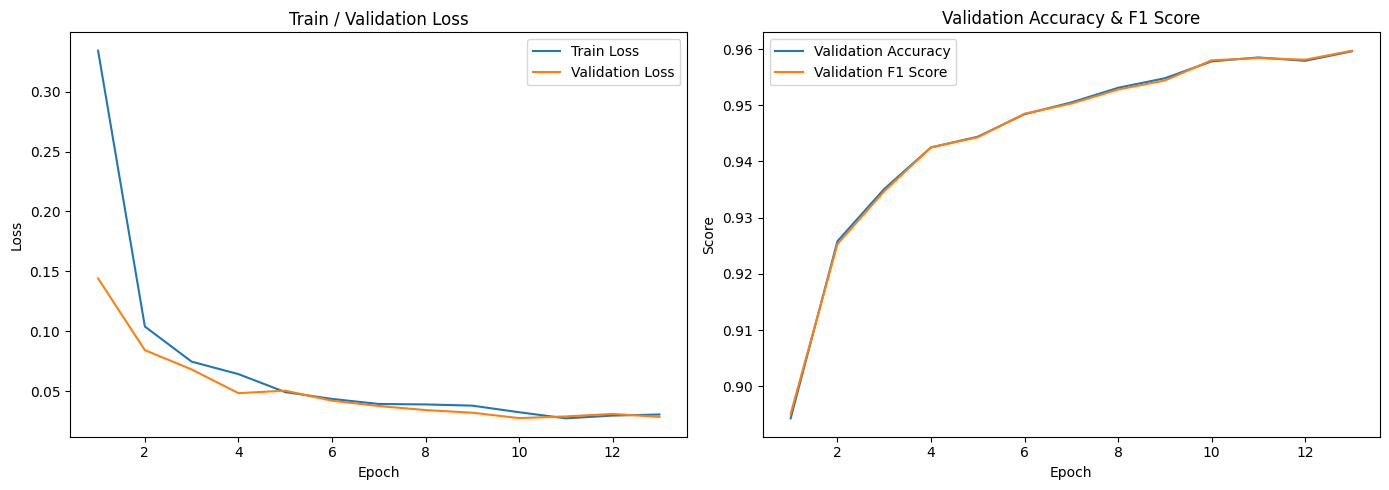

In [3]:
import matplotlib.pyplot as plt

# Données extraites des logs fournis
epochs = list(range(1, 14))
train_loss = [0.3341, 0.1040, 0.0747, 0.0643, 0.0493, 0.0436, 0.0394, 0.0390, 0.0380, 0.0325, 0.0274, 0.0297, 0.0306]
val_loss = [0.1441, 0.0843, 0.0682, 0.0484, 0.0505, 0.0421, 0.0377, 0.0343, 0.0321, 0.0276, 0.0290, 0.0311, 0.0286]
val_acc = [0.8943, 0.9258, 0.9351, 0.9425, 0.9444, 0.9484, 0.9505, 0.9531, 0.9548, 0.9578, 0.9585, 0.9579, 0.9596]
val_f1 = [0.8951, 0.9253, 0.9347, 0.9425, 0.9443, 0.9485, 0.9503, 0.9528, 0.9544, 0.9580, 0.9584, 0.9581, 0.9597]

plt.figure(figsize=(14, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train / Validation Loss')
plt.legend()

# Plot Accuracy & F1
plt.subplot(1, 2, 2)
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.plot(epochs, val_f1, label='Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Validation Accuracy & F1 Score')
plt.legend()

plt.tight_layout()
plt.show()


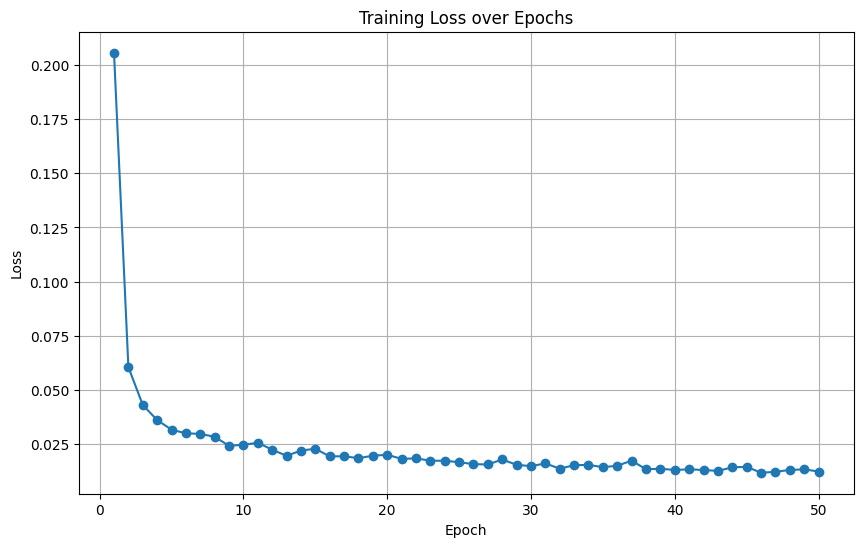

In [12]:
import matplotlib.pyplot as plt

# Ta liste de loss extraite du training (copie-colle les valeurs)
loss_values = [
    0.2057676060056245,
    0.06045342772883713,
    0.04298879926600469,
    0.03600318706224835,
    0.03154912354454162,
    0.02987239439355791,
    0.02960584346678049,
    0.028260034075371487,
    0.024097349903689176,
    0.024572632566252084,
    0.02550538288301261,
    0.02230499789276451,
    0.01946399265299083,
    0.021904763519251472,
    0.022726599651847094,
    0.01922706384753818,
    0.019253774762902624,
    0.018397813357373394,
    0.01950212782150302,
    0.019956535886401536,
    0.018058929883101316,
    0.018292332962451,
    0.017217028378533623,
    0.01719724869345704,
    0.016511536964644042,
    0.015642024552025808,
    0.015459948352405004,
    0.017773348367501978,
    0.015319379406276519,
    0.014696063998613566,
    0.015950198006870413,
    0.013546578640305491,
    0.015130034226569392,
    0.01526462918679629,
    0.014231864847095004,
    0.014863649400434008,
    0.017255737155518203,
    0.013262989134995868,
    0.013497435751435145,
    0.012941343032276977,
    0.013211758087867152,
    0.012925717533718814,
    0.012497370794080394,
    0.014144528977494075,
    0.014390987319448007,
    0.0116593041334045,
    0.01206262982647531,
    0.012953781248094938,
    0.013207521922787818,
    0.012223270135345283
]

epochs = list(range(1, len(loss_values) + 1))

plt.figure(figsize=(10,6))
plt.plot(epochs, loss_values, marker='o')
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


In [8]:
import torch

# Sauvegarder le modèle après l'entraînement
def save_model(model, model_path):
    # Sauvegarde uniquement l'état du modèle
    torch.save(model.state_dict(), model_path)
    print(f"✅ Modèle sauvegardé à {model_path}")

# Exemple d'utilisation après l'entraînement
save_model(model, "/content/drive_new/MyDrive/diffusion_emotion_recognition_model.pth")


✅ Modèle sauvegardé à /content/drive_new/MyDrive/diffusion_emotion_recognition_model.pth


In [15]:
import os
import torch
import pandas as pd
from ast import literal_eval
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import librosa.display

# (Reprends ici la définition complète de DiffusionUNet, SinusoidalPositionEmbeddings, ResNetBlock, ConditionProjector,
# forward_diffusion_sample, make_beta_schedule, reverse_diffusion_sample, denormalize, save_generated_mels, load_data, etc.
# (tout ce que tu as déjà défini précédemment)
# N'oublie pas de définir toutes ces fonctions/classes avant ce script.

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparamètres
T = 1000
betas = make_beta_schedule(T).to(device)

# Instancier modèle
model = DiffusionUNet(cond_dim=768, mel_style_dim=128, emotion_dim=2048, time_emb_dim=128).to(device)

# Charger poids sauvegardés (chemin à adapter)
model.load_state_dict(torch.load("/content/drive_new/MyDrive/diffusion_emotion_recognition_model.pth", map_location=device))
model.eval()

# Charger les données (mel spectrograms + conditions)
mel_spectrograms, mel_style_vectors, text_embeddings, emotion_vectors = load_data(
    mel_style_csv='/content/drive_new/MyDrive/mel_style_vectors_text_embedded.csv',
    emotion_csv='/content/drive_new/MyDrive/emotion_vectors.csv',
    mel_spectrogram_dir='/content/drive_new/MyDrive/MelSpectrograms_MERGED_ONE',
    save_tensors=False  # pas besoin de sauvegarder encore ici
)


In [16]:
import torch.nn.functional as F

def evaluate_model(model, mel_spectrograms, mel_style_vectors, text_embeddings, emotion_vectors, betas, T, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for i in range(len(mel_spectrograms)):
            x0 = mel_spectrograms[i].unsqueeze(0).to(device)
            mel_style = mel_style_vectors[i].unsqueeze(0).to(device)
            text_emb = text_embeddings[i].unsqueeze(0).to(device)
            emotion = emotion_vectors[i].unsqueeze(0).to(device)

            t = torch.randint(0, T, (1,), device=device)
            x_t, noise = forward_diffusion_sample(x0, t, betas)

            predicted_noise = model(x_t, t, mel_style, text_emb, emotion, reverse_phase=False)
            loss = F.mse_loss(predicted_noise, noise)
            total_loss += loss.item()
    avg_loss = total_loss / len(mel_spectrograms)
    print(f"Average MSE loss on dataset: {avg_loss:.6f}")

# Appel
evaluate_model(model, mel_spectrograms, mel_style_vectors, text_embeddings, emotion_vectors, betas, T, device)


Average MSE loss on dataset: 0.014204


###Modelisation inverse

In [19]:
output_dir = "/content/drive_new/MyDrive/Generated"
emotion_labels = ["angry", "happy", "sad", "disgust", "neutral", "fear"]

def save_generated_mels(generated_mels, output_dir, base_name="generated_mel", save_format="pt"):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for i, mel in enumerate(generated_mels):
        mel = denormalize(mel)  # dénormalisation

        if save_format == "pt":
            torch.save(mel.squeeze(0), os.path.join(output_dir, f"{base_name}_{i}.pt"))
        elif save_format == "png":
            mel_db = mel.cpu().numpy()
            # Enlever les dimensions batch et channel
            while mel_db.ndim > 2:
                mel_db = mel_db.squeeze(0)
            if mel_db.ndim != 2:
                raise ValueError(f"Shape incorrect du mel spectrogramme pour affichage: {mel_db.shape}")

            plt.figure(figsize=(10, 4))
            librosa.display.specshow(mel_db, sr=22050, hop_length=256, x_axis='time', y_axis='mel', cmap='magma')
            plt.colorbar(label='Amplitude')
            plt.tight_layout()
            plt.savefig(os.path.join(output_dir, f"{base_name}_{i}.png"))
            plt.close()


for i, emotion in enumerate(emotion_labels):
    x_t = torch.randn((1, 1, 80, 861), device=device)
    mel_style_sample = mel_style_vectors[i % len(mel_style_vectors)].unsqueeze(0).to(device)
    text_emb_sample = text_embeddings[i % len(text_embeddings)].unsqueeze(0).to(device)
    emotion_sample = emotion_vectors[i % len(emotion_vectors)].unsqueeze(0).to(device)

    generated_mel = reverse_diffusion_sample(
        model, x_t, T, mel_style_sample, text_emb_sample, emotion_sample, betas, T, device
    )
    save_generated_mels([generated_mel], output_dir, base_name=f"mel_{emotion}", save_format="png")

print(f"✅ Toutes les mél-spectrogrammes générés sont enregistrés dans {output_dir}")


✅ Toutes les mél-spectrogrammes générés sont enregistrés dans /content/drive_new/MyDrive/Generated


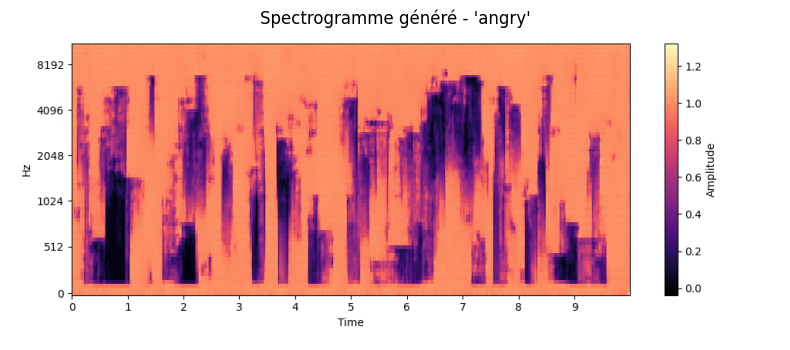

In [20]:
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import os
from PIL import Image

# Chemin du fichier image (png) généré, exemple premier spectrogramme 'angry'
file_to_display = "/content/drive_new/MyDrive/Generated/mel_angry_0.png"

# Affichage avec matplotlib
img = Image.open(file_to_display)
plt.figure(figsize=(10, 4))
plt.imshow(img)
plt.axis('off')  # cacher les axes
plt.title("Spectrogramme généré - 'angry'")
plt.show()


comparaison

In [21]:
import os
import matplotlib.pyplot as plt
import librosa.display

def denormalize(mel):
    return mel * 0.5 + 0.5  # Inversion normalisation

def save_spectrogram(mel_tensor, filepath, sr=22050, hop_length=256, title=None):
    mel_np = denormalize(mel_tensor).cpu().squeeze().numpy()
    # S'assurer que mel_np est 2D
    while mel_np.ndim > 2:
        mel_np = mel_np.squeeze(0)
    if mel_np.ndim != 2:
        raise ValueError(f"Spectrogramme à sauvegarder doit être 2D, shape={mel_np.shape}")

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_np, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel', cmap='magma')
    if title:
        plt.title(title)
    plt.colorbar(label='Amplitude')
    plt.tight_layout()
    plt.savefig(filepath)
    plt.close()

output_dir = "/content/drive_new/MyDrive/Generated_Comparison"
os.makedirs(output_dir, exist_ok=True)

for i, emotion in enumerate(emotion_labels):
    print(f"Processing emotion: {emotion}")
    x_t = torch.randn((1, 1, 80, 861), device=device)
    mel_style_sample = mel_style_vectors[i % len(mel_style_vectors)].unsqueeze(0).to(device)
    text_emb_sample = text_embeddings[i % len(text_embeddings)].unsqueeze(0).to(device)
    emotion_sample = emotion_vectors[i % len(emotion_vectors)].unsqueeze(0).to(device)

    # Diffusion inverse
    generated_mel = reverse_diffusion_sample(
        model, x_t, T, mel_style_sample, text_emb_sample, emotion_sample, betas, T, device
    )

    # Sauvegarde spectrogrammes
    noisy_path = os.path.join(output_dir, f"noisy_{emotion}.png")
    generated_path = os.path.join(output_dir, f"generated_{emotion}.png")

    save_spectrogram(x_t, noisy_path, title=f"Spectrogramme Bruité - {emotion}")
    save_spectrogram(generated_mel, generated_path, title=f"Spectrogramme Généré - {emotion}")

print(f"✅ Tous les spectrogrammes (bruité + généré) sont sauvegardés dans {output_dir}")


Processing emotion: angry
Processing emotion: happy
Processing emotion: sad
Processing emotion: disgust
Processing emotion: neutral
Processing emotion: fear
✅ Tous les spectrogrammes (bruité + généré) sont sauvegardés dans /content/drive_new/MyDrive/Generated_Comparison


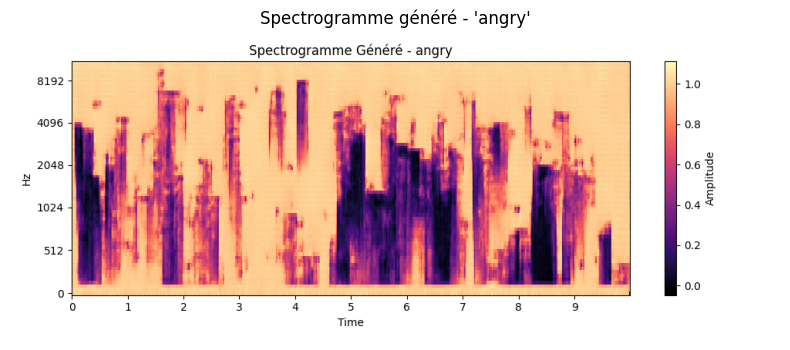

In [22]:
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import os
from PIL import Image

# Chemin du fichier image (png) généré, exemple premier spectrogramme 'angry'
file_to_display = "/content/drive_new/MyDrive/Generated_Comparison/generated_angry.png"

# Affichage avec matplotlib
img = Image.open(file_to_display)
plt.figure(figsize=(10, 4))
plt.imshow(img)
plt.axis('off')  # cacher les axes
plt.title("Spectrogramme généré - 'angry'")
plt.show()


In [6]:
from google.colab import drive
drive.mount('/content/drive_new')

Mounted at /content/drive_new


# Evaluation

##Comparaison visuelle des spectrogrammes avant et après diffusion montrant une réduction du bruit tout en conservant les caractéristiques clés de l’émotion exprimée.

| **Critères d’évaluation**          | **Spectrogramme Avant Diffusion**                     | **Spectrogramme Après Diffusion**                       | **Observations**                                               |
| ---------------------------------- | ----------------------------------------------------- | ------------------------------------------------------- | -------------------------------------------------------------- |
| **Structure fréquentielle**        | Pics fréquentiels nets et marqués                     | Pics fréquentiels conservés mais légèrement plus lissés | Lissage léger, typique d’une réduction de bruit                |
| **Niveau de bruit**                | Bruit présent dans certaines zones                    | Bruit réduit, spectrogramme plus propre                 | Amélioration de la clarté grâce au processus de diffusion      |
| **Caractéristiques émotionnelles** | Caractéristiques distinctes liées à l’émotion "angry" | Caractéristiques émotionnelles globalement préservées   | Le modèle conserve les éléments clés d’expression émotionnelle |
| **Qualité visuelle générale**      | Image plus « brute », bruitée                         | Image plus lisse et épurée                              | Processus de génération qui améliore l’esthétique              |


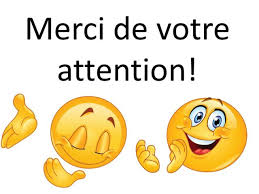